<a href="https://colab.research.google.com/github/ShanRinna/DL3/blob/main/DNN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
import tensorflow as tf
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [2]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [3]:
#df = pd.read_csv('/content/sample_data/House_Rent_Dataset.csv') #y:連續變數
# Colab
df = pd.read_csv('/content/House_Rent_Dataset.csv')
df

Rent  Size  BHK  Bathroom Furnishing Status       City
0     10000  1100    2         2       Unfurnished    Kolkata
1     20000   800    2         1    Semi-Furnished    Kolkata
2     17000  1000    2         1    Semi-Furnished    Kolkata
3     10000   800    2         1       Unfurnished    Kolkata
4      7500   850    2         1       Unfurnished    Kolkata
...     ...   ...  ...       ...               ...        ...
4741  15000  1000    2         2    Semi-Furnished  Hyderabad
4742  29000  2000    3         3    Semi-Furnished  Hyderabad
4743  35000  1750    3         3    Semi-Furnished  Hyderabad
4744  45000  1500    3         2    Semi-Furnished  Hyderabad
4745  15000  1000    2         2       Unfurnished  Hyderabad

[4746 rows x 6 columns]

In [4]:
dummied_df=pd.get_dummies(df,columns=['Furnishing Status','City'])
dummied_df

Rent  Size  BHK  Bathroom  Furnishing Status_Furnished  \
0     10000  1100    2         2                            0   
1     20000   800    2         1                            0   
2     17000  1000    2         1                            0   
3     10000   800    2         1                            0   
4      7500   850    2         1                            0   
...     ...   ...  ...       ...                          ...   
4741  15000  1000    2         2                            0   
4742  29000  2000    3         3                            0   
4743  35000  1750    3         3                            0   
4744  45000  1500    3         2                            0   
4745  15000  1000    2         2                            0   

      Furnishing Status_Semi-Furnished  Furnishing Status_Unfurnished  \
0                                    0                              1   
1                                    1                              0   
2                                    1                              0   
3                                    0                              1   
4                                    0                              1   
...                                ...                            ...   
4741                                 1                              0   
4742                                 1                              0   
4743                                 1                              0   
4744                                 1                              0   
4745                                 0                              1   

      City_Bangalore  City_Chennai  City_Delhi  City_Hyderabad  City_Kolkata  \
0                  0             0           0               0             1   
1                  0             0           0               0             1   
2                  0             0           0               0             1   
3                  0             0           0               0             1   
4                  0             0           0               0             1   
...              ...           ...         ...             ...           ...   
4741               0             0           0               1             0   
4742               0             0           0               1             0   
4743               0             0           0               1             0   
4744               0             0           0               1             0   
4745               0             0           0               1             0   

      City_Mumbai  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
4741            0  
4742            0  
4743            0  
4744            0  
4745            0  

[4746 rows x 13 columns]

In [5]:
dummied_df.to_csv('/content/sample_data/House_Rent_Dataset.csv',index=False, header=True)
# Colab
#dummied_new_df.to_csv('House_Rent_dummied.csv',index=False, header=True)
print('Export complete...')

Export complete...


In [6]:
#set x (make prediction) with minimax
x=dummied_df.drop(['Rent'],axis=1).copy()  #training:模型內部評估testing:跨模型評估(選模)

#set y (want to predict)
y=dummied_df['Rent'].copy()

In [7]:
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scaling=MMscaler.fit_transform(x)
scaled_x=pd.DataFrame(data=scaling)
scaled_x.columns=x.columns
scaled_x.head()

Size  BHK  Bathroom  Furnishing Status_Furnished  \
0  0.136421  0.2  0.111111                          0.0   
1  0.098874  0.2  0.000000                          0.0   
2  0.123905  0.2  0.000000                          0.0   
3  0.098874  0.2  0.000000                          0.0   
4  0.105131  0.2  0.000000                          0.0   

   Furnishing Status_Semi-Furnished  Furnishing Status_Unfurnished  \
0                               0.0                            1.0   
1                               1.0                            0.0   
2                               1.0                            0.0   
3                               0.0                            1.0   
4                               0.0                            1.0   

   City_Bangalore  City_Chennai  City_Delhi  City_Hyderabad  City_Kolkata  \
0             0.0           0.0         0.0             0.0           1.0   
1             0.0           0.0         0.0             0.0           1.0   
2             0.0           0.0         0.0             0.0           1.0   
3             0.0           0.0         0.0             0.0           1.0   
4             0.0           0.0         0.0             0.0           1.0   

   City_Mumbai  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

In [8]:
#prepare dataset with scaling
#Split the data (split into 80% training data & 20% testing data) (lock seed)
x_train,x_test,y_train,y_test=train_test_split(scaled_x,y,test_size=0.2,random_state=5)

In [9]:
# Quick recap: Total of 12 features in the data set
scaled_x.head()

Size  BHK  Bathroom  Furnishing Status_Furnished  \
0  0.136421  0.2  0.111111                          0.0   
1  0.098874  0.2  0.000000                          0.0   
2  0.123905  0.2  0.000000                          0.0   
3  0.098874  0.2  0.000000                          0.0   
4  0.105131  0.2  0.000000                          0.0   

   Furnishing Status_Semi-Furnished  Furnishing Status_Unfurnished  \
0                               0.0                            1.0   
1                               1.0                            0.0   
2                               1.0                            0.0   
3                               0.0                            1.0   
4                               0.0                            1.0   

   City_Bangalore  City_Chennai  City_Delhi  City_Hyderabad  City_Kolkata  \
0             0.0           0.0         0.0             0.0           1.0   
1             0.0           0.0         0.0             0.0           1.0   
2             0.0           0.0         0.0             0.0           1.0   
3             0.0           0.0         0.0             0.0           1.0   
4             0.0           0.0         0.0             0.0           1.0   

   City_Mumbai  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

In [10]:
from keras.losses import mse
from keras.backend import sqrt #loss function can choose，RMSE使值域較小

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects #keras has to login
get_custom_objects().update({'my_RMSE': my_RMSE}) #my_RMSE 自定，後面用此可呼叫出

In [11]:
# Some self define functions for building deep neural networks
def dense_generator(model_name,layers,last_layer_neurons,activation_fun='relu'):
    n=last_layer_neurons
    neurons=n
    for i in range(0,layers):
        neurons=neurons*2
        model_name.add(Dense(units=neurons, activation=activation_fun))

In [88]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 4 more dense layers
dense_generator(model,3,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.01,beta_1=0.5)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [89]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 1s 16ms/step - loss: 31636.4238 - MAPE: 103.2088 - val_loss: 21549.6055 - val_MAPE: 68.4582
Epoch 2/100
48/48 [==============================] - 1s 11ms/step - loss: 27221.6152 - MAPE: 86.2051 - val_loss: 36390.7773 - val_MAPE: 88.5214
Epoch 3/100
48/48 [==============================] - 1s 11ms/step - loss: 25836.9746 - MAPE: 69.5630 - val_loss: 27724.0977 - val_MAPE: 49.3427
Epoch 4/100
48/48 [==============================] - 0s 10ms/step - loss: 23760.4688 - MAPE: 64.4407 - val_loss: 36934.4062 - val_MAPE: 268.9264
Epoch 5/100
48/48 [==============================] - 0s 10ms/step - loss: 24076.7832 - MAPE: 69.2237 - val_loss: 23509.1602 - val_MAPE: 66.3775
Epoch 6/100
48/48 [==============================] - 0s 10ms/step - loss: 18244.3477 - MAPE: 51.9537 - val_loss: 14942.6768 - val_MAPE: 46.1527
Epoch 7/100
48/48 [==============================] - 1s 11ms/step - loss: 16446.1914 - MAPE: 47.4677 - val_loss: 18460.8730 - val_MAPE

In [90]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

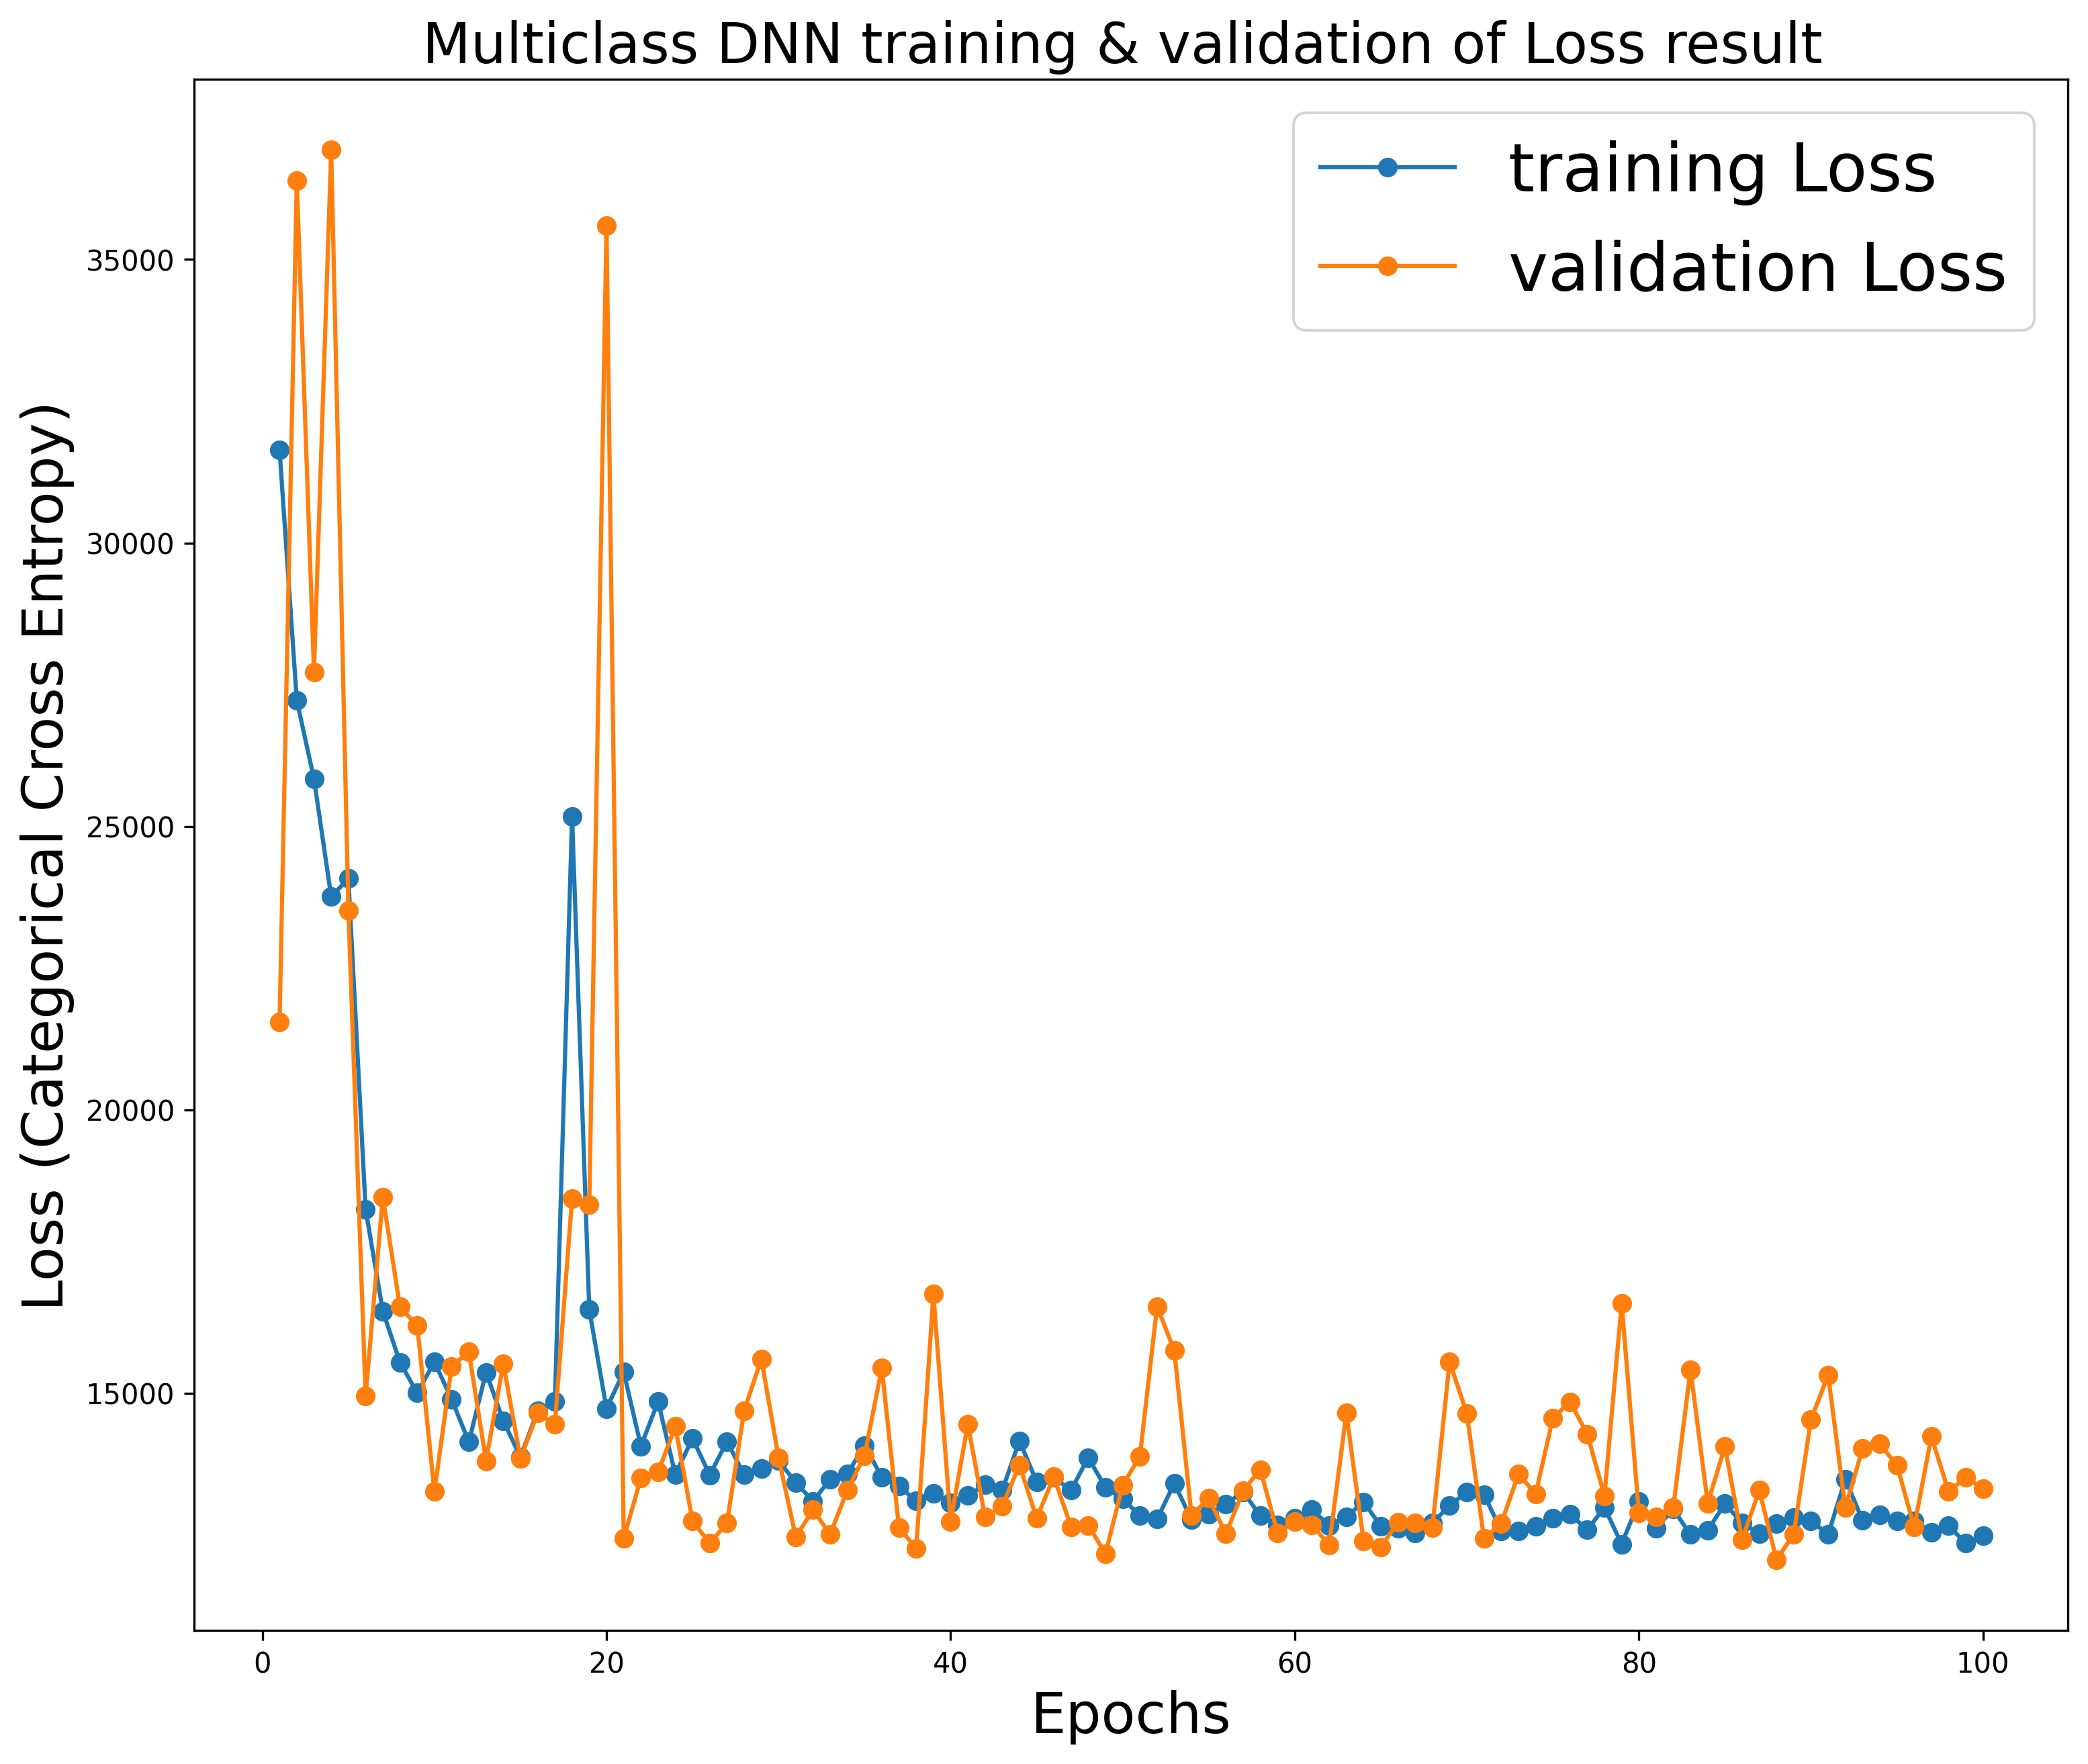

In [91]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [17]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,3,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.01,beta_1=0.7)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [18]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 3s 24ms/step - loss: 24745.9551 - MAPE: 73.8969 - val_loss: 17096.6230 - val_MAPE: 37.4684
Epoch 2/100
48/48 [==============================] - 1s 12ms/step - loss: 20449.9277 - MAPE: 58.0170 - val_loss: 19332.4980 - val_MAPE: 39.9125
Epoch 3/100
48/48 [==============================] - 1s 11ms/step - loss: 15353.7695 - MAPE: 43.1077 - val_loss: 14113.5654 - val_MAPE: 33.0810
Epoch 4/100
48/48 [==============================] - 0s 10ms/step - loss: 15714.9629 - MAPE: 44.1329 - val_loss: 17540.4668 - val_MAPE: 35.0522
Epoch 5/100
48/48 [==============================] - 0s 10ms/step - loss: 15649.5557 - MAPE: 43.7729 - val_loss: 13071.2656 - val_MAPE: 31.5942
Epoch 6/100
48/48 [==============================] - 1s 11ms/step - loss: 16415.5723 - MAPE: 43.3639 - val_loss: 15254.0996 - val_MAPE: 34.1300
Epoch 7/100
48/48 [==============================] - 1s 11ms/step - loss: 16856.3984 - MAPE: 49.1704 - val_loss: 14541.9180 - val_MAPE: 

In [19]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

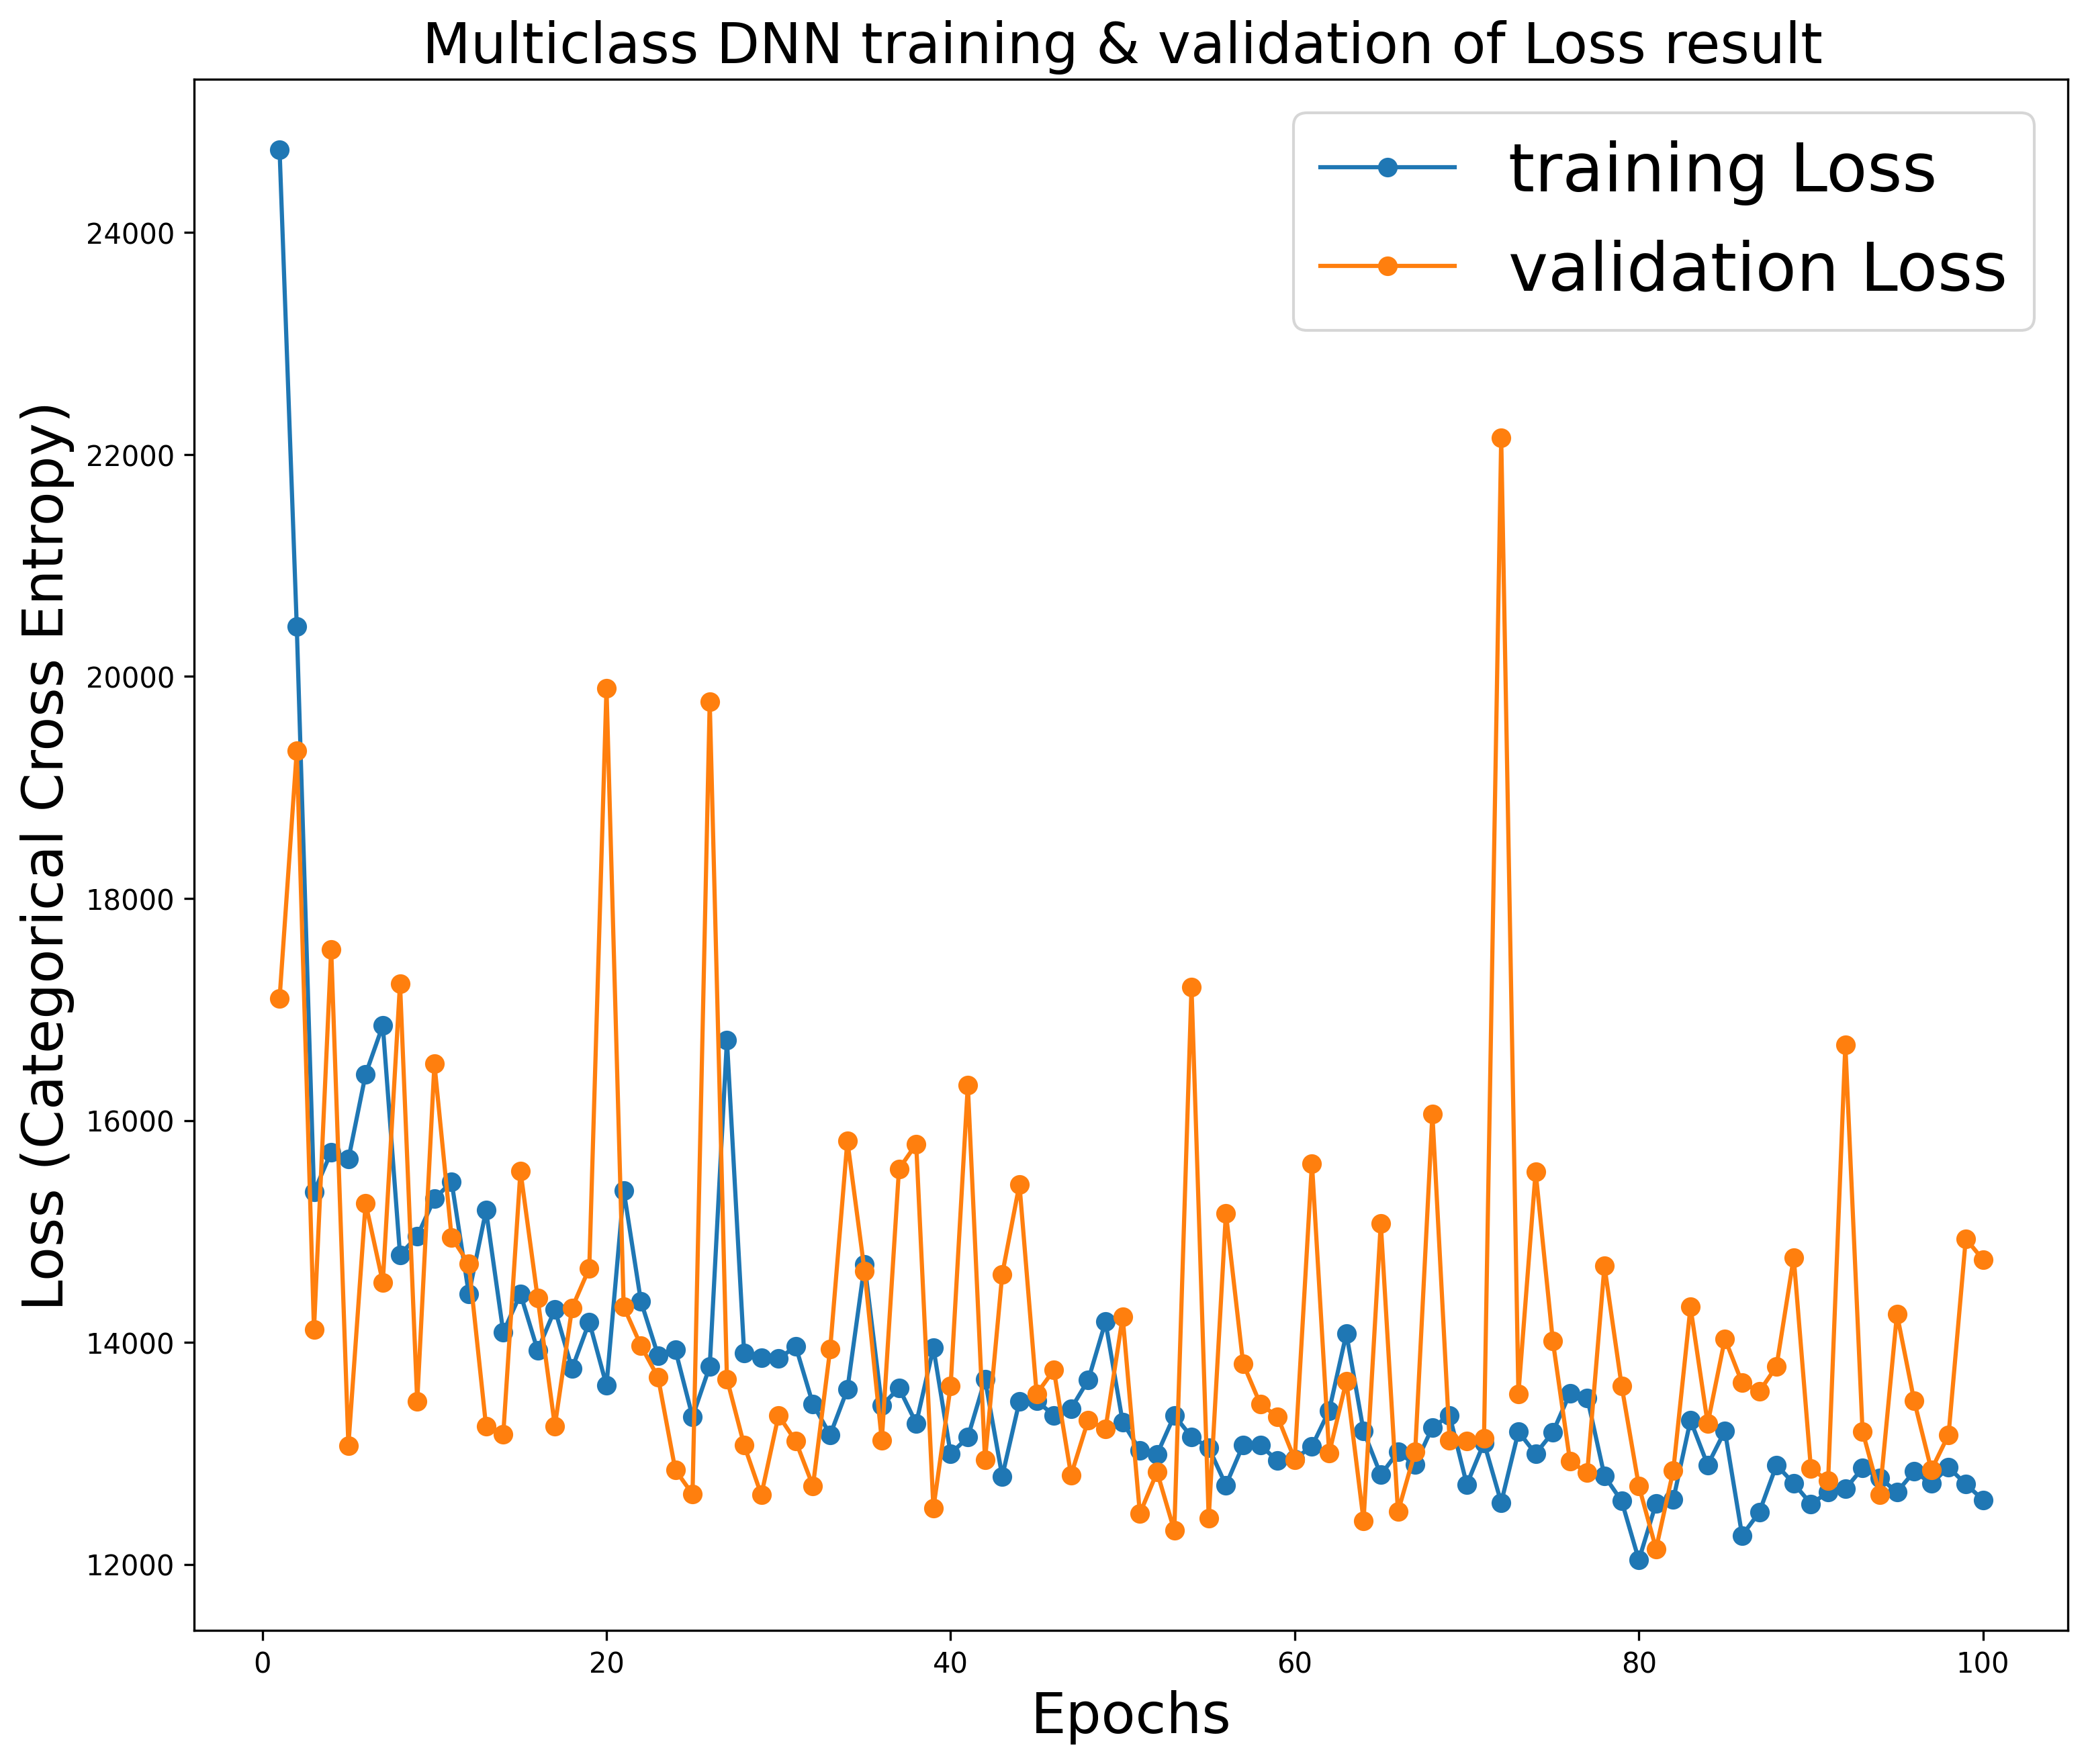

In [20]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [21]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,3,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.01,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [22]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 1s 16ms/step - loss: 25606.5156 - MAPE: 71.3994 - val_loss: 17605.6816 - val_MAPE: 33.7664
Epoch 2/100
48/48 [==============================] - 1s 11ms/step - loss: 16716.7539 - MAPE: 47.0832 - val_loss: 14686.3232 - val_MAPE: 47.1511
Epoch 3/100
48/48 [==============================] - 1s 11ms/step - loss: 15478.6816 - MAPE: 42.2676 - val_loss: 18835.6914 - val_MAPE: 35.2867
Epoch 4/100
48/48 [==============================] - 1s 11ms/step - loss: 14827.3926 - MAPE: 41.1952 - val_loss: 13525.0352 - val_MAPE: 47.3901
Epoch 5/100
48/48 [==============================] - 0s 10ms/step - loss: 16708.4355 - MAPE: 46.7933 - val_loss: 15485.8740 - val_MAPE: 41.2879
Epoch 6/100
48/48 [==============================] - 1s 10ms/step - loss: 15317.3809 - MAPE: 44.6153 - val_loss: 14673.4160 - val_MAPE: 43.9412
Epoch 7/100
48/48 [==============================] - 0s 10ms/step - loss: 14541.1064 - MAPE: 42.3273 - val_loss: 12793.5254 - val_MAPE: 

In [23]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

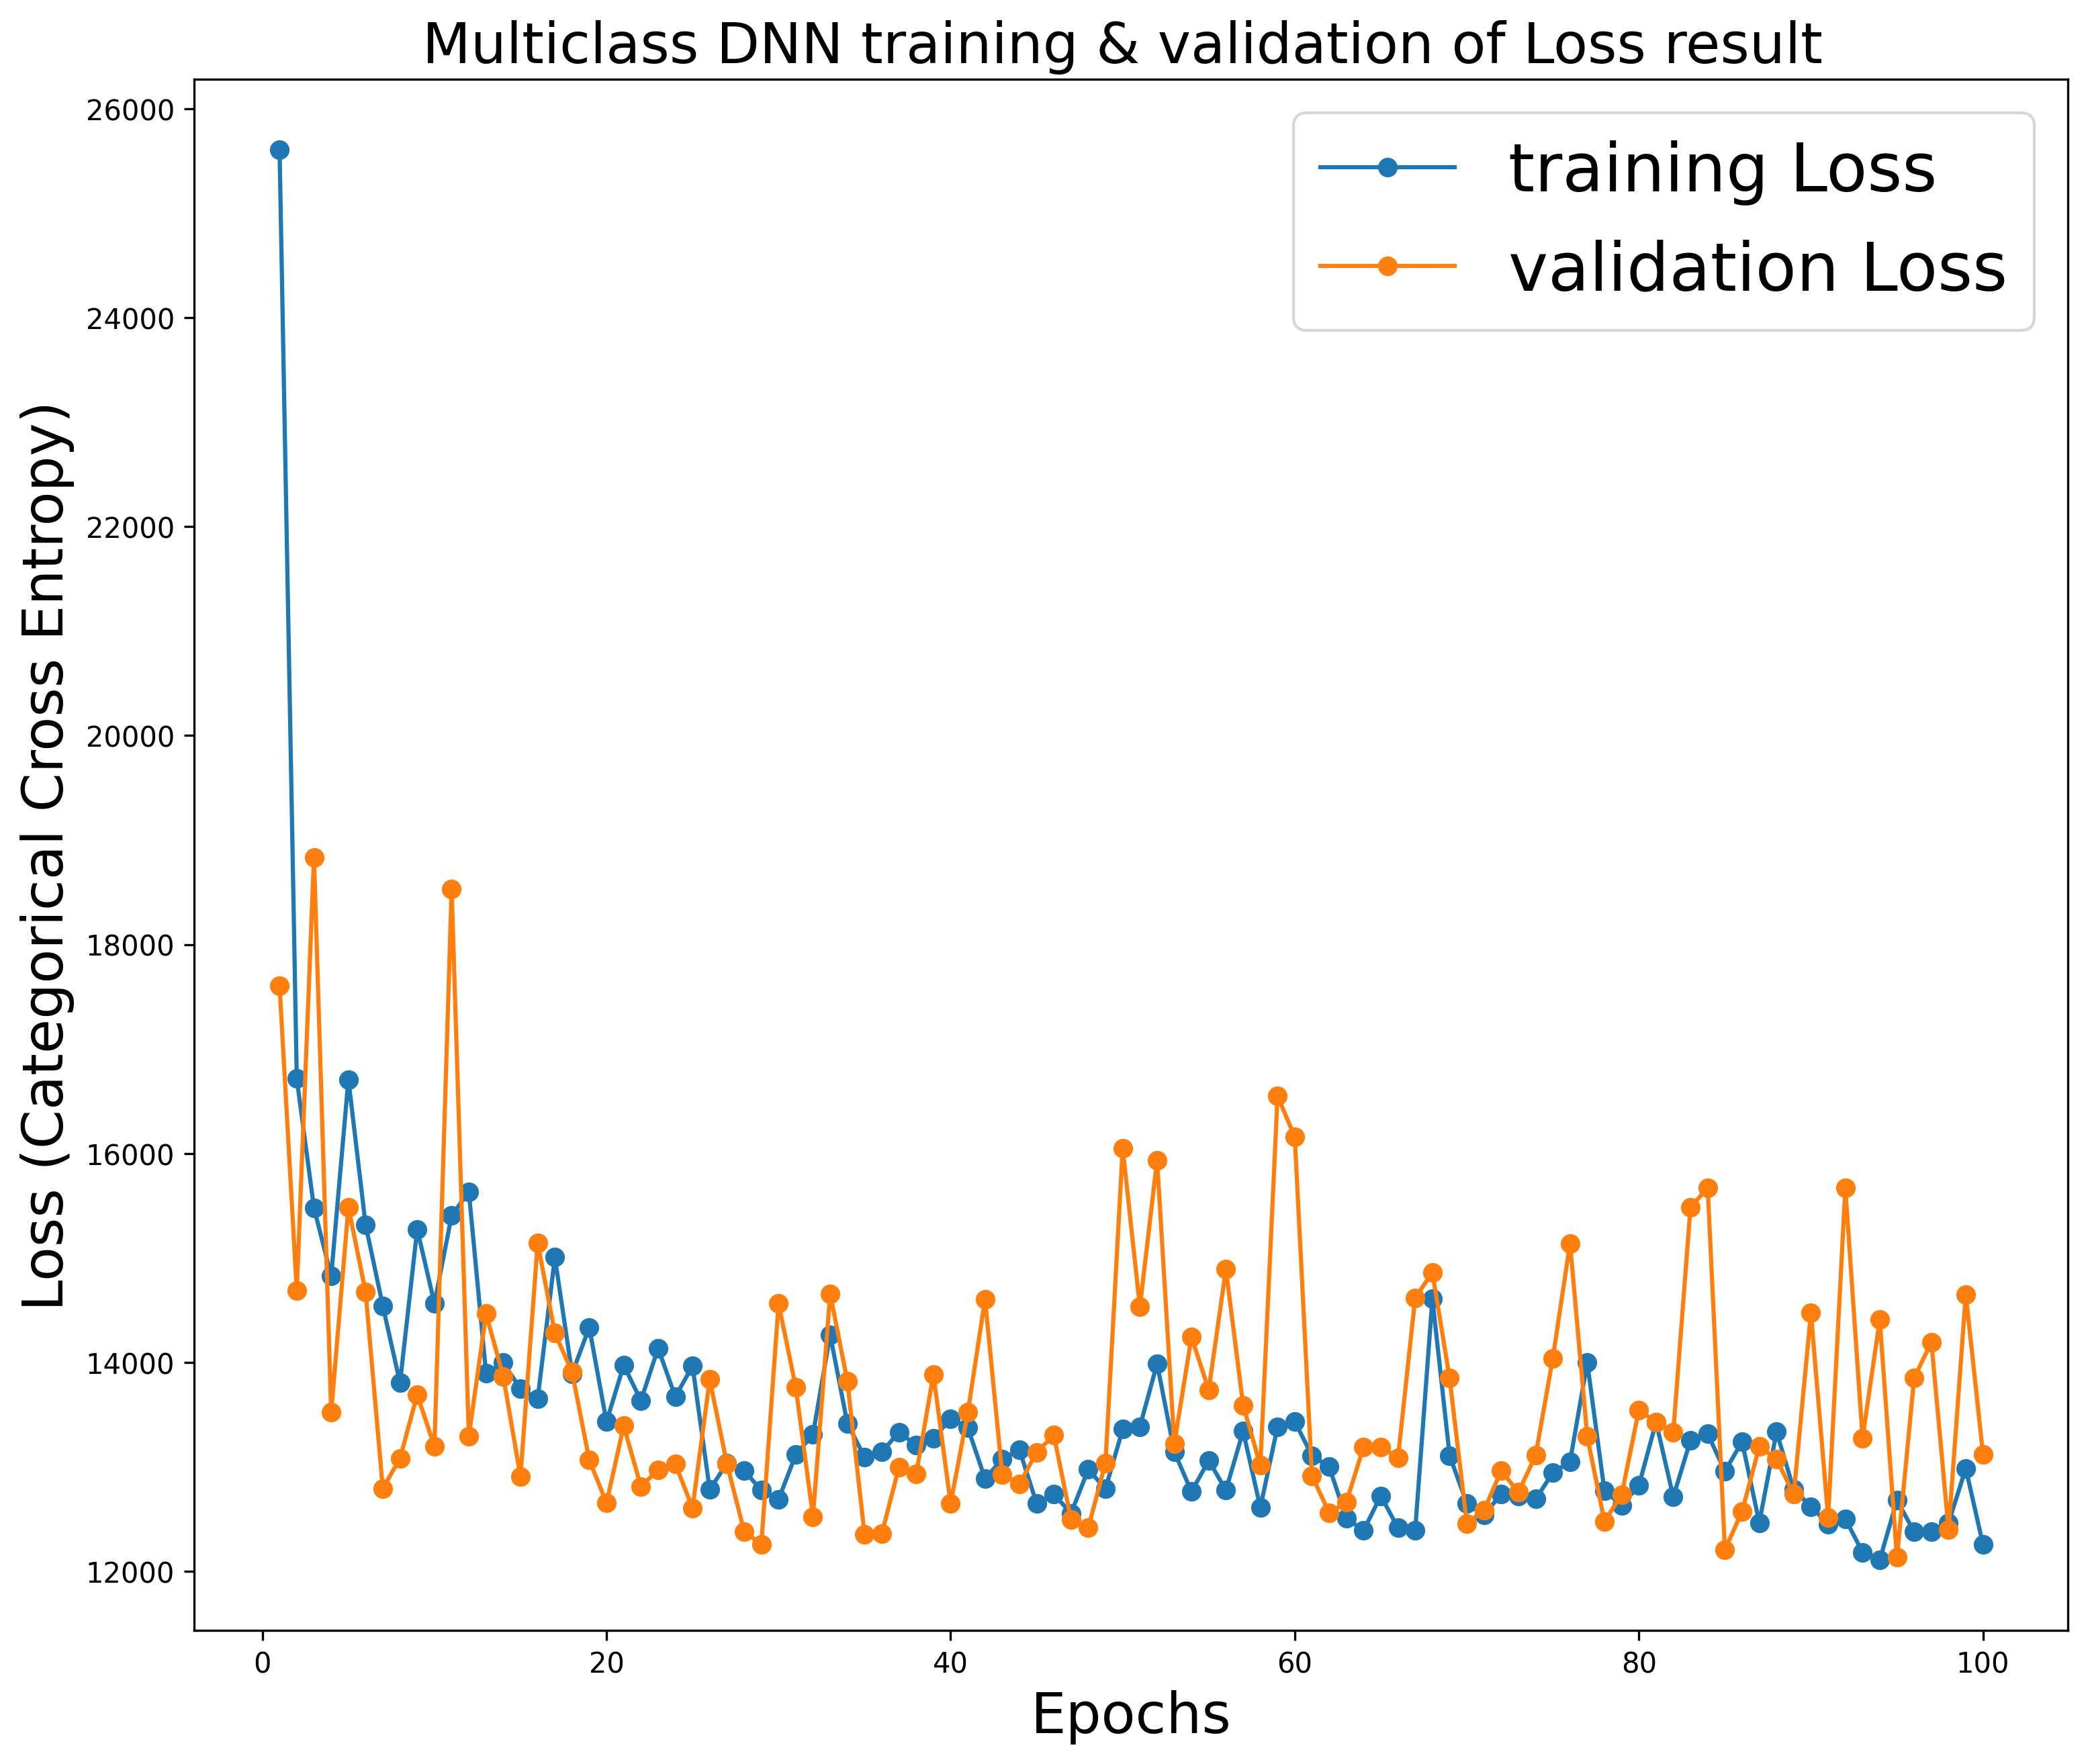

In [24]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [59]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,3,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.005,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [60]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 1s 15ms/step - loss: 28734.1152 - MAPE: 85.4985 - val_loss: 18963.1035 - val_MAPE: 40.1836
Epoch 2/100
48/48 [==============================] - 0s 10ms/step - loss: 17324.7832 - MAPE: 46.0585 - val_loss: 13883.1426 - val_MAPE: 45.0773
Epoch 3/100
48/48 [==============================] - 0s 10ms/step - loss: 15224.5547 - MAPE: 42.1438 - val_loss: 13265.1172 - val_MAPE: 32.4609
Epoch 4/100
48/48 [==============================] - 1s 11ms/step - loss: 14294.0146 - MAPE: 38.9193 - val_loss: 15480.0752 - val_MAPE: 32.5668
Epoch 5/100
48/48 [==============================] - 1s 11ms/step - loss: 14623.8896 - MAPE: 41.0469 - val_loss: 13734.5459 - val_MAPE: 38.5967
Epoch 6/100
48/48 [==============================] - 1s 11ms/step - loss: 14780.0000 - MAPE: 43.5792 - val_loss: 13193.2568 - val_MAPE: 31.0621
Epoch 7/100
48/48 [==============================] - 1s 12ms/step - loss: 14335.7129 - MAPE: 38.2951 - val_loss: 12834.1055 - val_MAPE: 

In [61]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

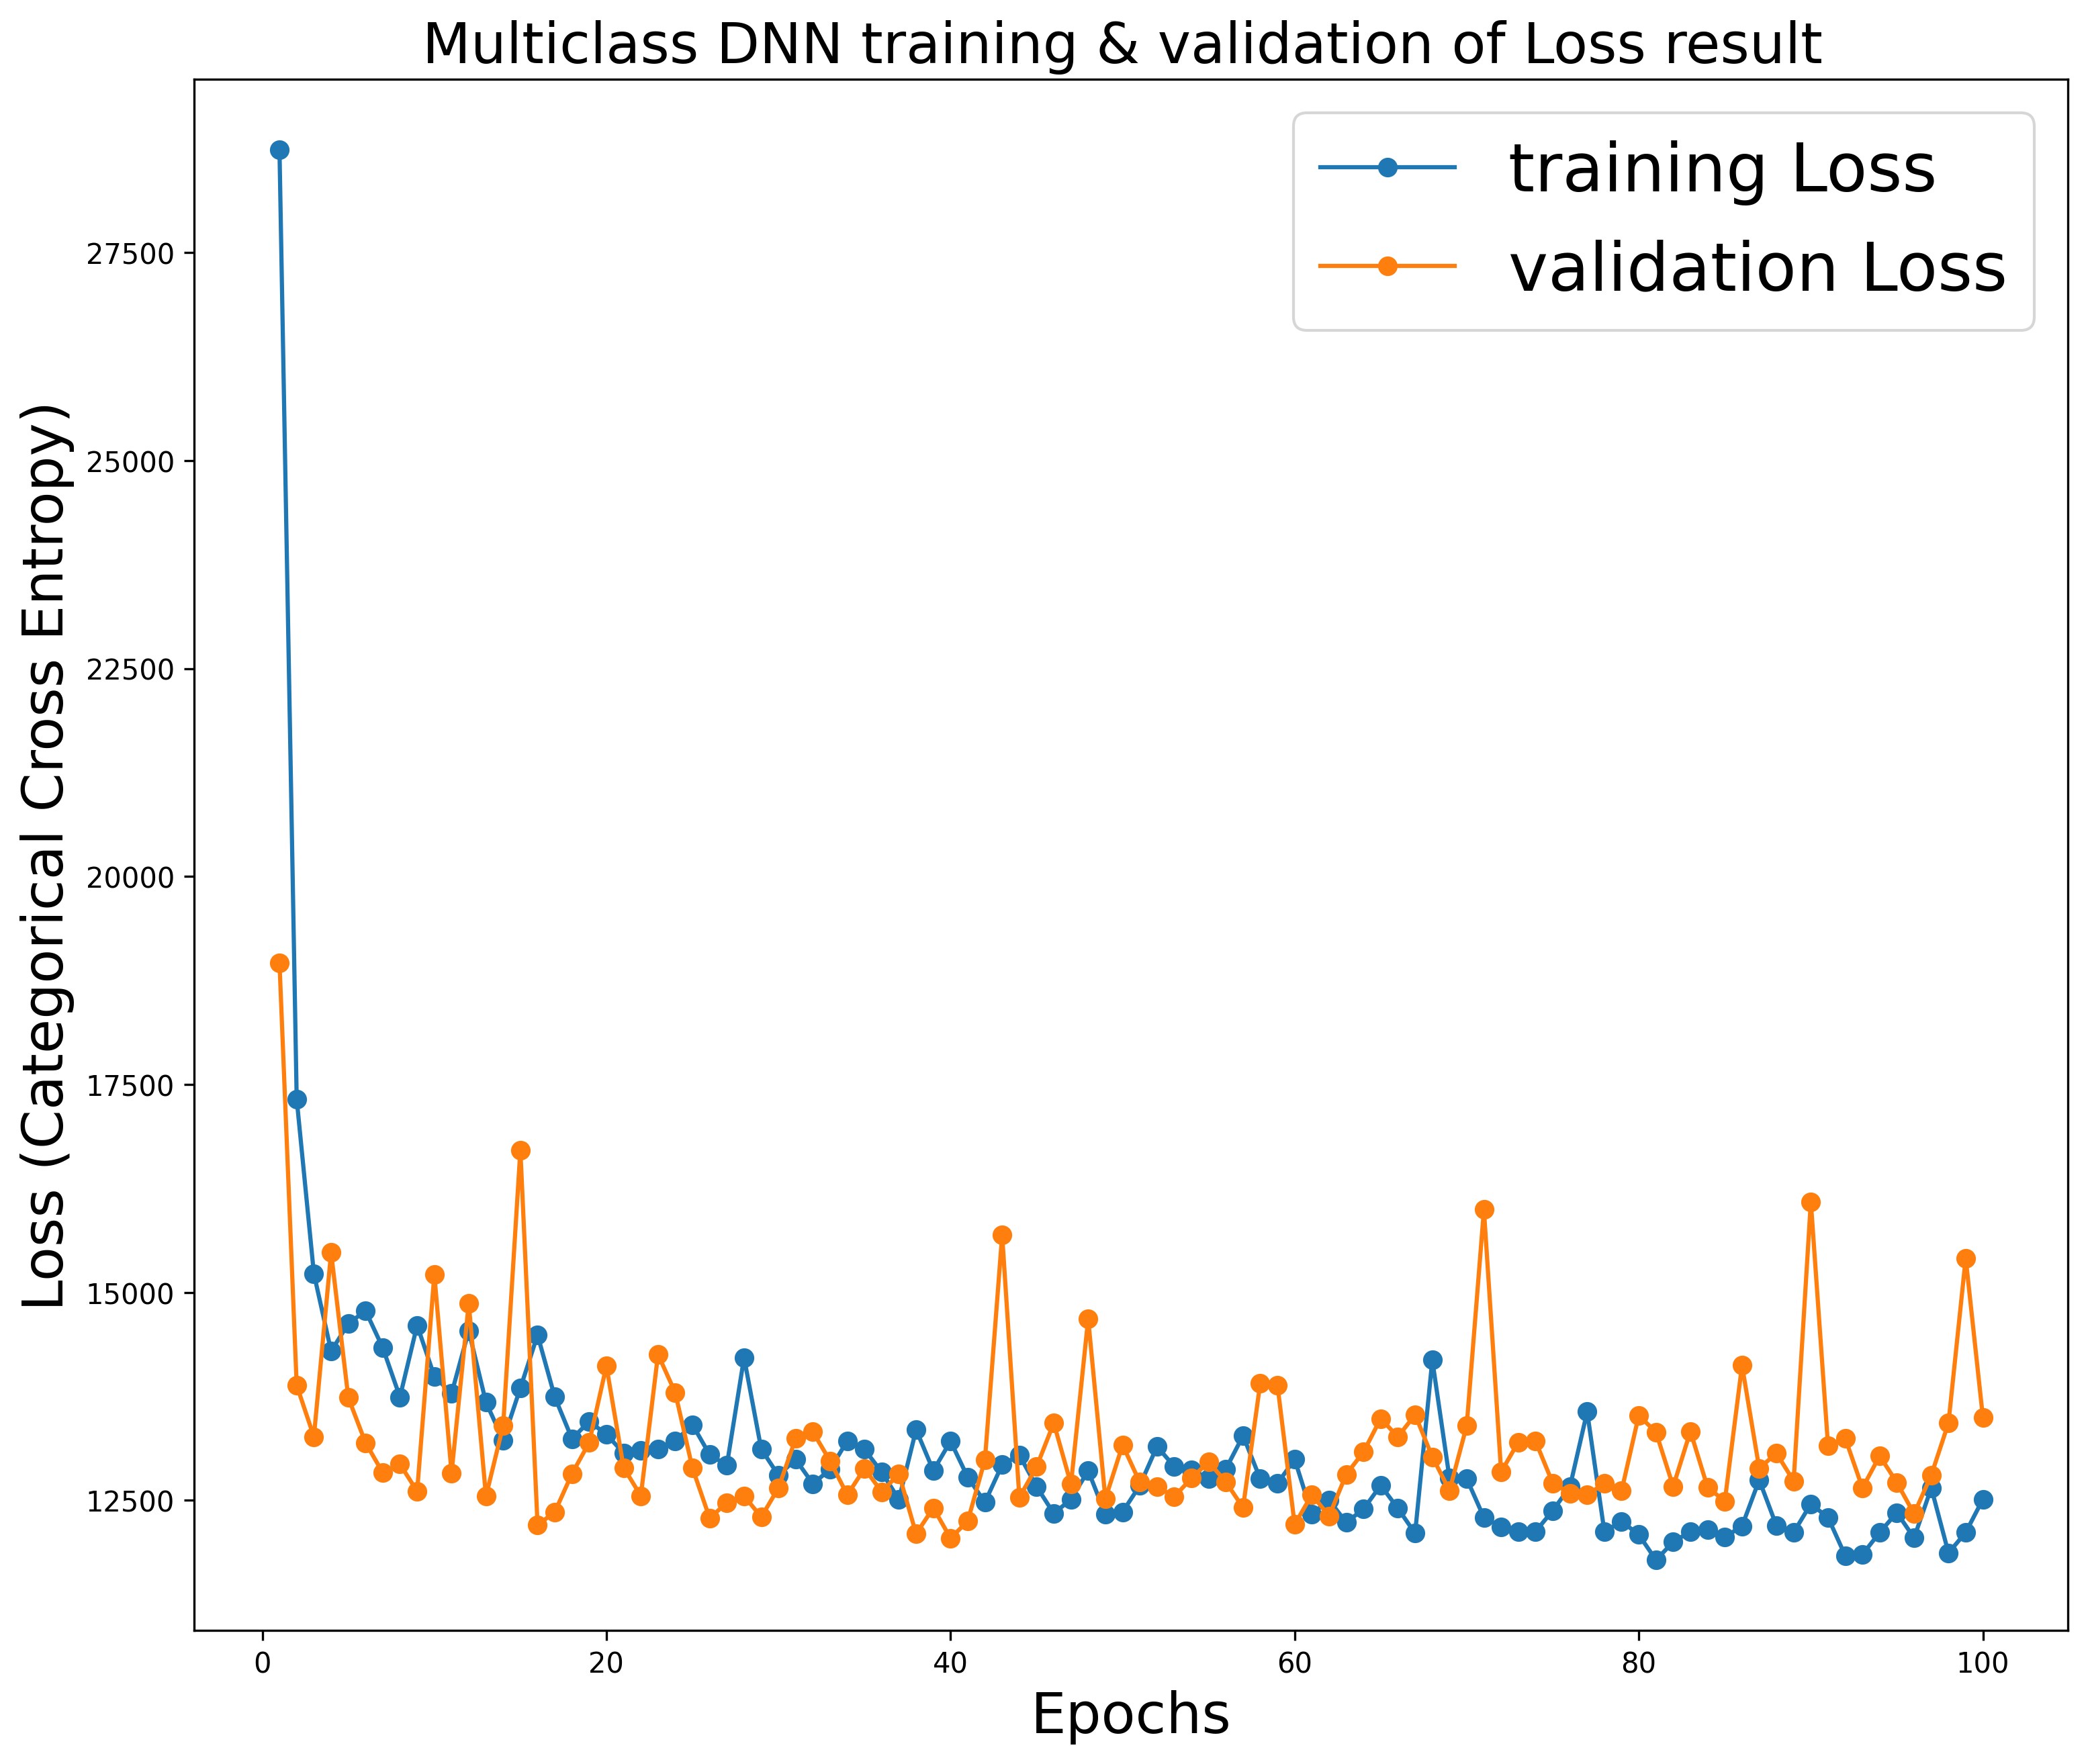

In [62]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [63]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,3,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.005,beta_1=0.7)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [64]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 1s 16ms/step - loss: 26722.9375 - MAPE: 75.9276 - val_loss: 17745.8594 - val_MAPE: 66.5561
Epoch 2/100
48/48 [==============================] - 0s 10ms/step - loss: 18647.4277 - MAPE: 52.8403 - val_loss: 13817.3291 - val_MAPE: 34.7968
Epoch 3/100
48/48 [==============================] - 0s 10ms/step - loss: 15343.0557 - MAPE: 43.2699 - val_loss: 14267.4395 - val_MAPE: 33.3803
Epoch 4/100
48/48 [==============================] - 0s 10ms/step - loss: 15279.0029 - MAPE: 42.8766 - val_loss: 13213.3105 - val_MAPE: 32.2221
Epoch 5/100
48/48 [==============================] - 1s 11ms/step - loss: 14870.1025 - MAPE: 41.5400 - val_loss: 17507.8809 - val_MAPE: 36.2651
Epoch 6/100
48/48 [==============================] - 1s 12ms/step - loss: 14293.8691 - MAPE: 39.4408 - val_loss: 12499.5430 - val_MAPE: 32.0712
Epoch 7/100
48/48 [==============================] - 1s 12ms/step - loss: 14369.2441 - MAPE: 40.5014 - val_loss: 14257.5596 - val_MAPE: 

In [65]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

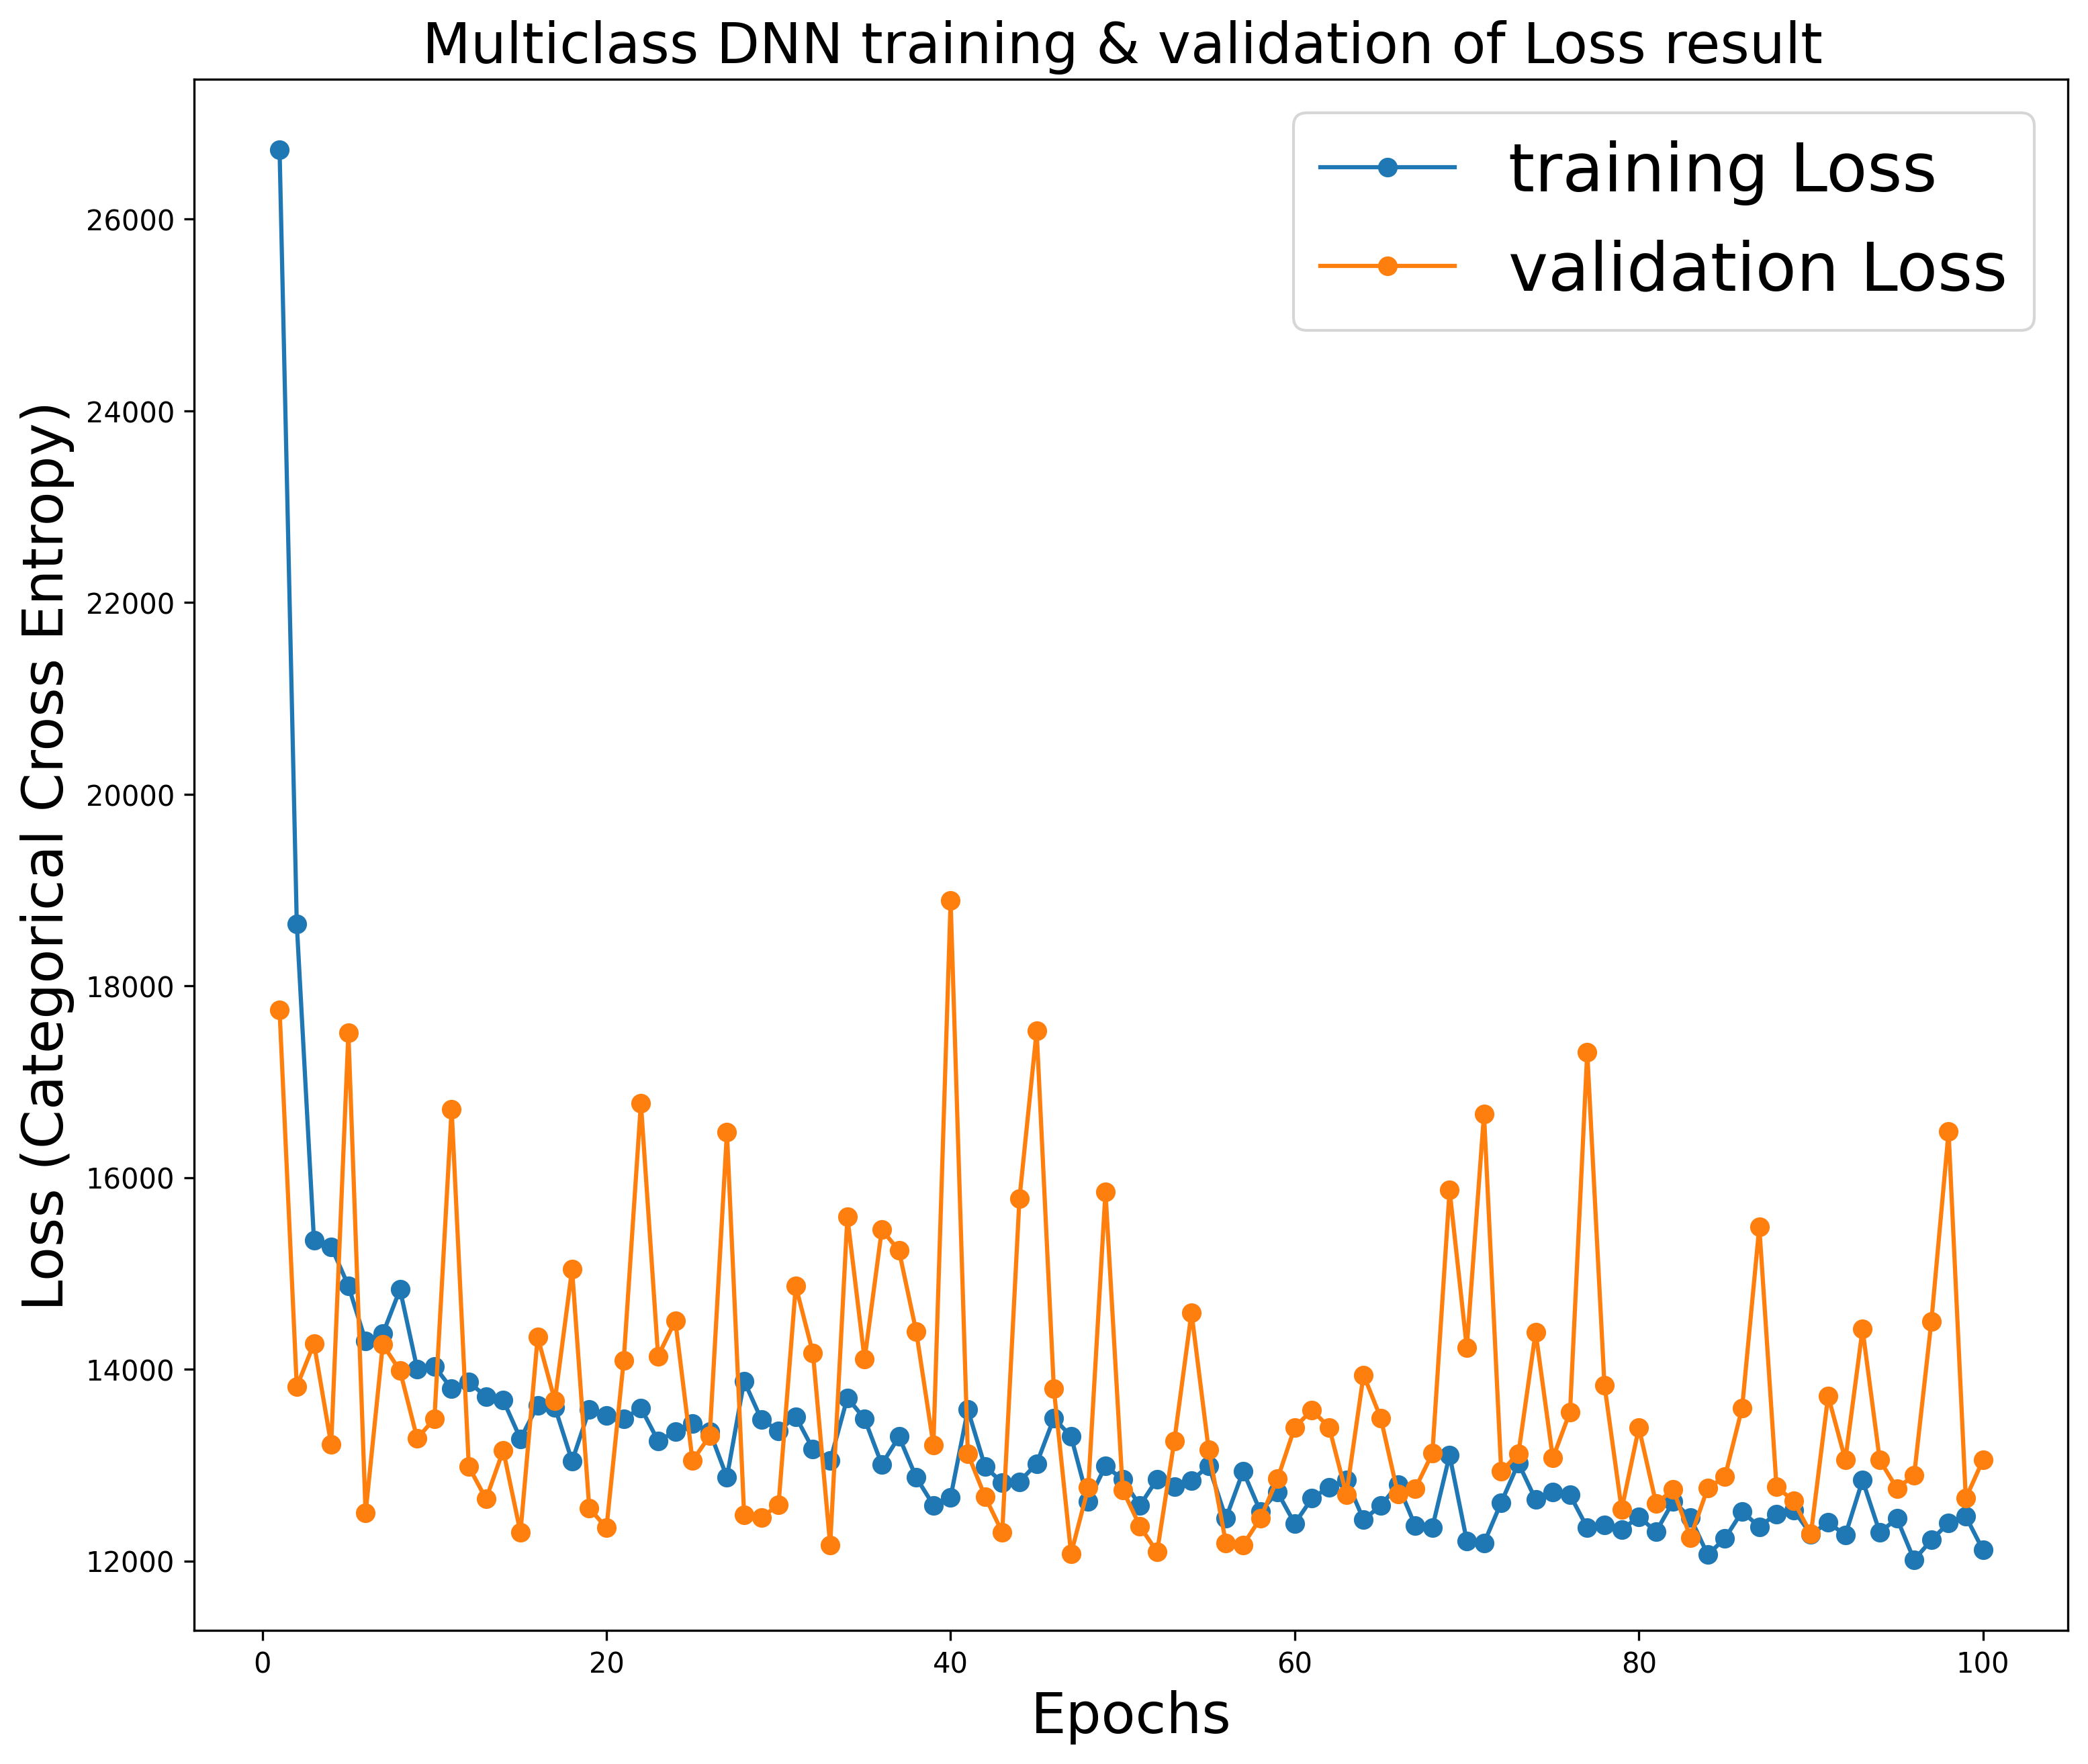

In [66]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [75]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,3,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.001,beta_1=0.7)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [76]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 1s 15ms/step - loss: 24841.3633 - MAPE: 69.4634 - val_loss: 21802.9180 - val_MAPE: 41.3807
Epoch 2/100
48/48 [==============================] - 0s 10ms/step - loss: 19079.0000 - MAPE: 47.0380 - val_loss: 17251.8711 - val_MAPE: 42.7281
Epoch 3/100
48/48 [==============================] - 1s 11ms/step - loss: 16769.0391 - MAPE: 44.7376 - val_loss: 14527.1670 - val_MAPE: 32.5936
Epoch 4/100
48/48 [==============================] - 0s 10ms/step - loss: 14989.5088 - MAPE: 39.5067 - val_loss: 14820.4395 - val_MAPE: 49.8511
Epoch 5/100
48/48 [==============================] - 0s 10ms/step - loss: 15275.6943 - MAPE: 42.3941 - val_loss: 13505.2314 - val_MAPE: 43.0725
Epoch 6/100
48/48 [==============================] - 0s 10ms/step - loss: 14367.2529 - MAPE: 38.5079 - val_loss: 14251.8740 - val_MAPE: 31.8951
Epoch 7/100
48/48 [==============================] - 0s 10ms/step - loss: 14936.1045 - MAPE: 41.4429 - val_loss: 12920.0947 - val_MAPE: 

In [77]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

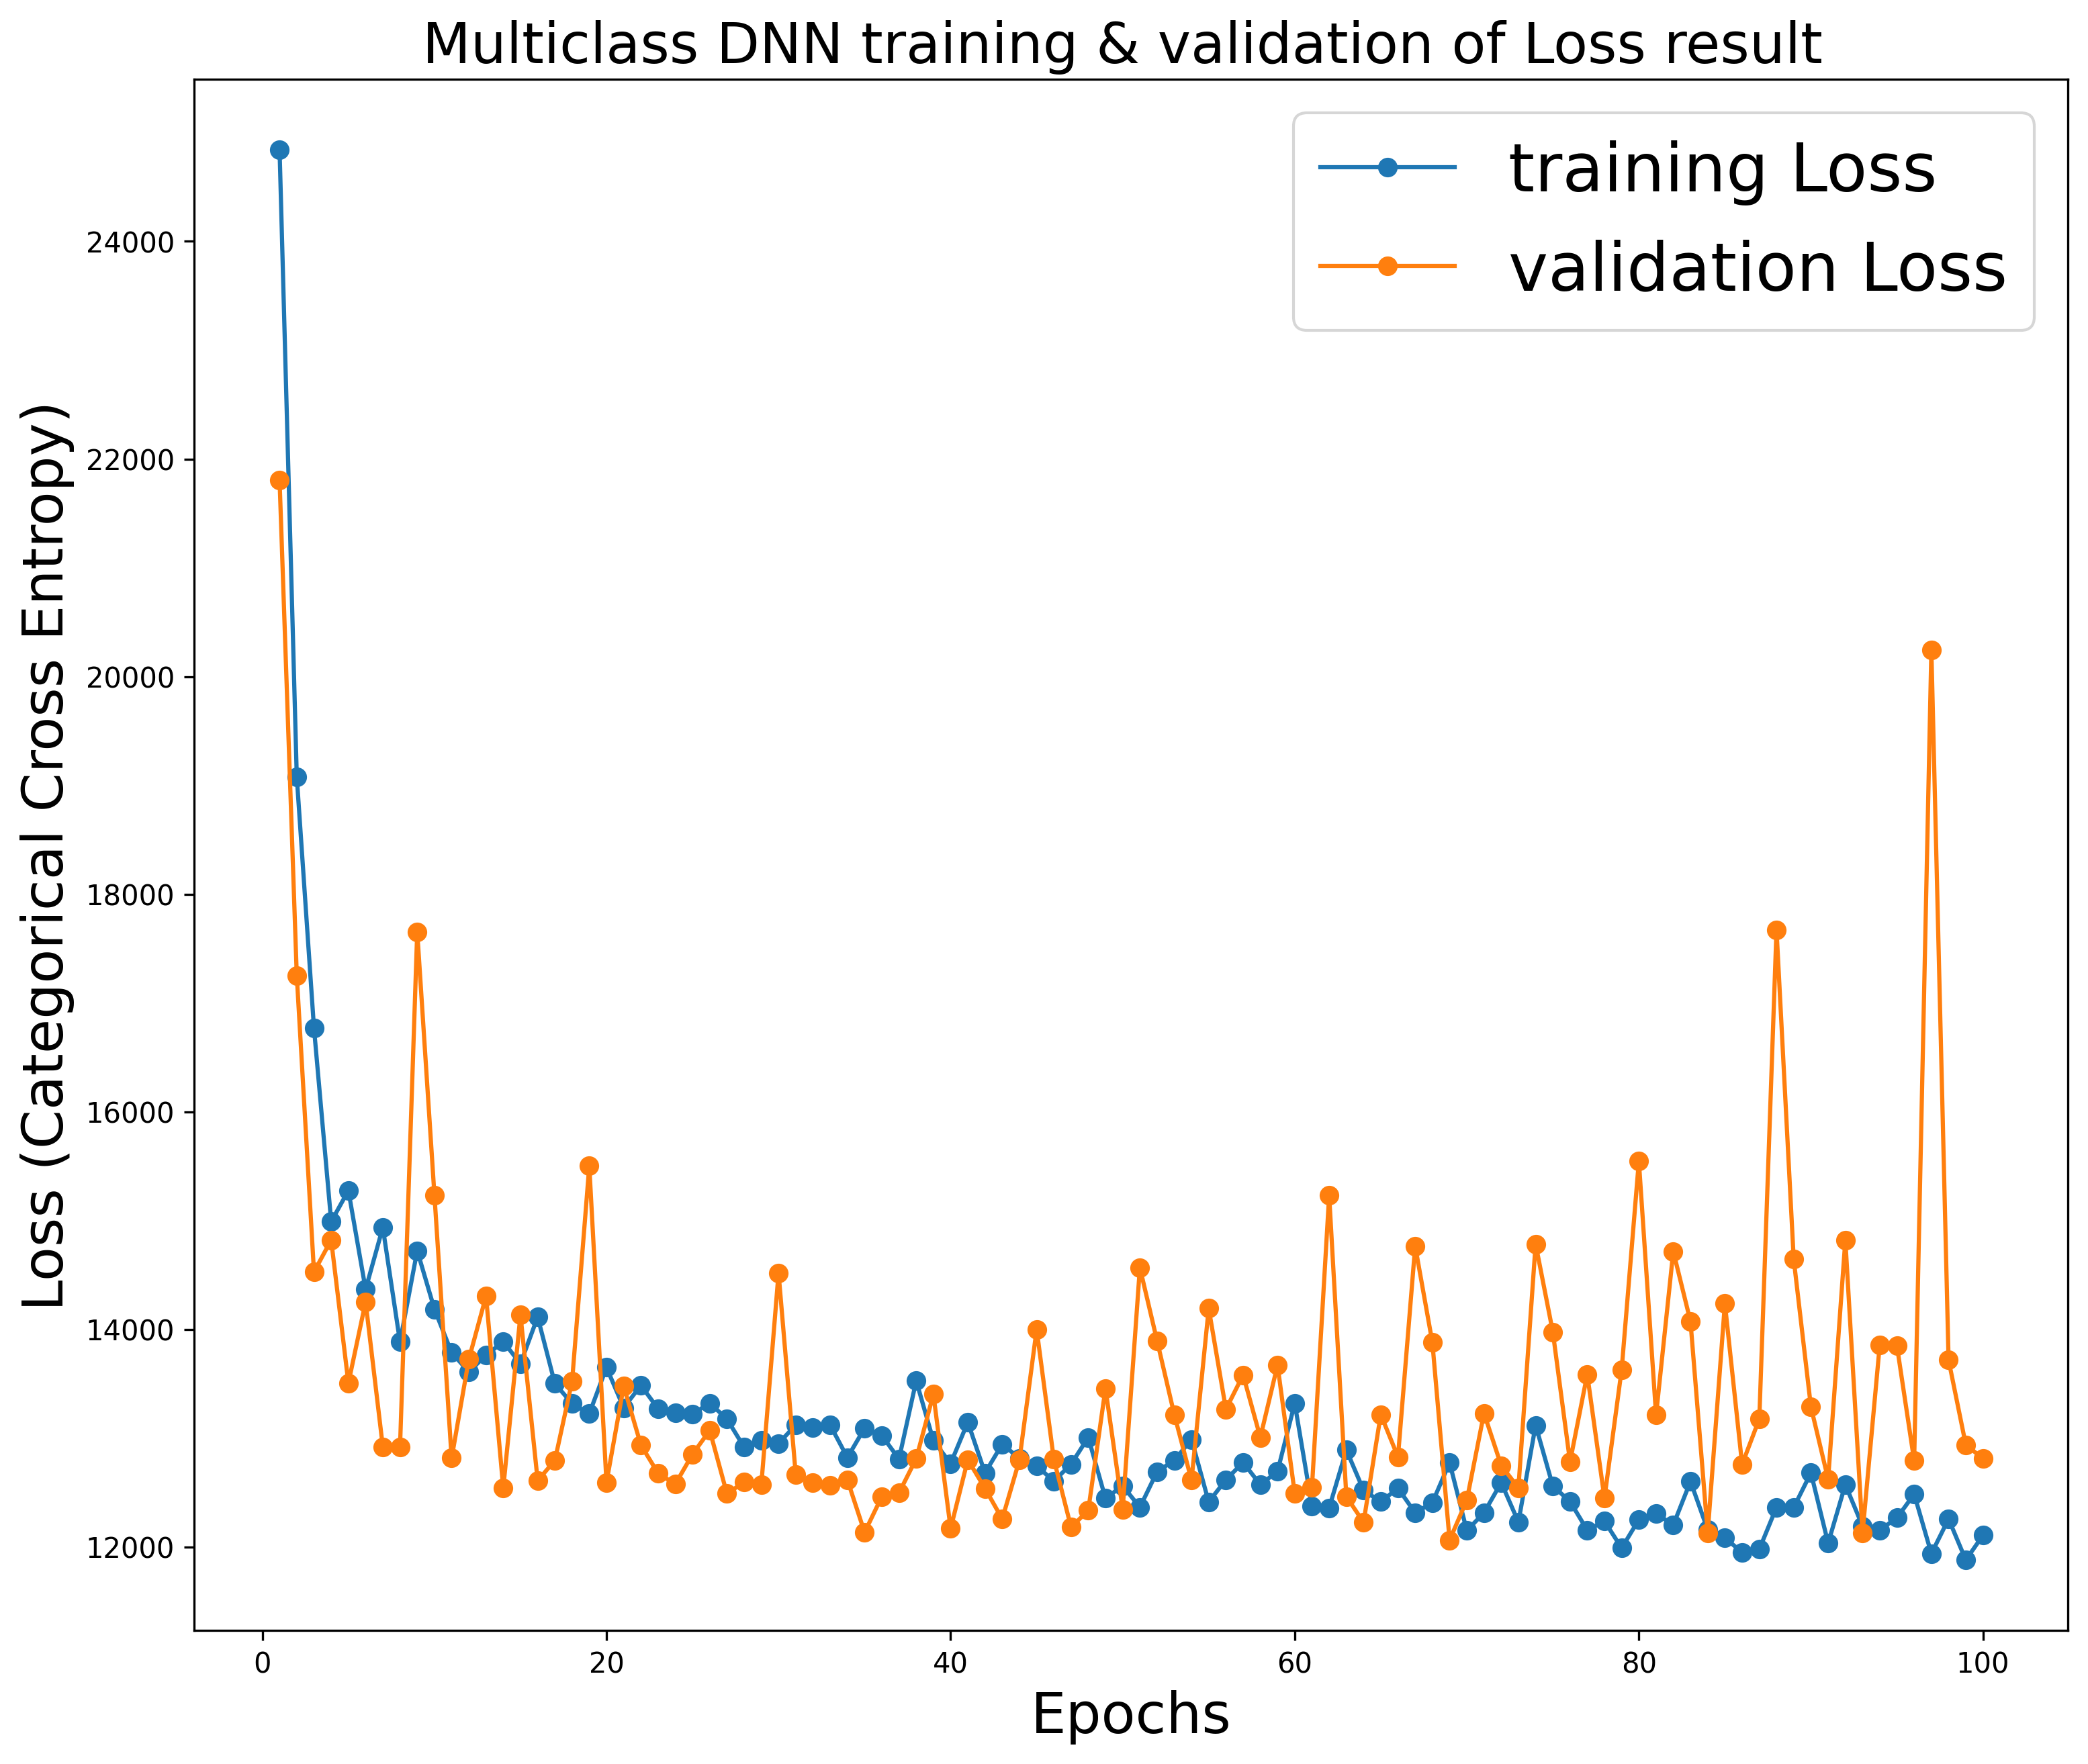

In [78]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [79]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,3,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.001,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [80]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 1s 15ms/step - loss: 25285.8691 - MAPE: 73.2850 - val_loss: 19400.5156 - val_MAPE: 56.3219
Epoch 2/100
48/48 [==============================] - 0s 10ms/step - loss: 17556.7070 - MAPE: 45.2227 - val_loss: 16682.8281 - val_MAPE: 35.4771
Epoch 3/100
48/48 [==============================] - 1s 11ms/step - loss: 15781.6465 - MAPE: 42.6834 - val_loss: 14905.9551 - val_MAPE: 35.1496
Epoch 4/100
48/48 [==============================] - 1s 12ms/step - loss: 14402.4873 - MAPE: 39.5035 - val_loss: 13332.2275 - val_MAPE: 32.4411
Epoch 5/100
48/48 [==============================] - 1s 12ms/step - loss: 14457.5439 - MAPE: 38.7373 - val_loss: 13485.2627 - val_MAPE: 31.4515
Epoch 6/100
48/48 [==============================] - 1s 11ms/step - loss: 14057.1816 - MAPE: 36.6239 - val_loss: 13097.3174 - val_MAPE: 36.7859
Epoch 7/100
48/48 [==============================] - 1s 11ms/step - loss: 14032.3271 - MAPE: 37.6572 - val_loss: 13713.6748 - val_MAPE: 

In [81]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

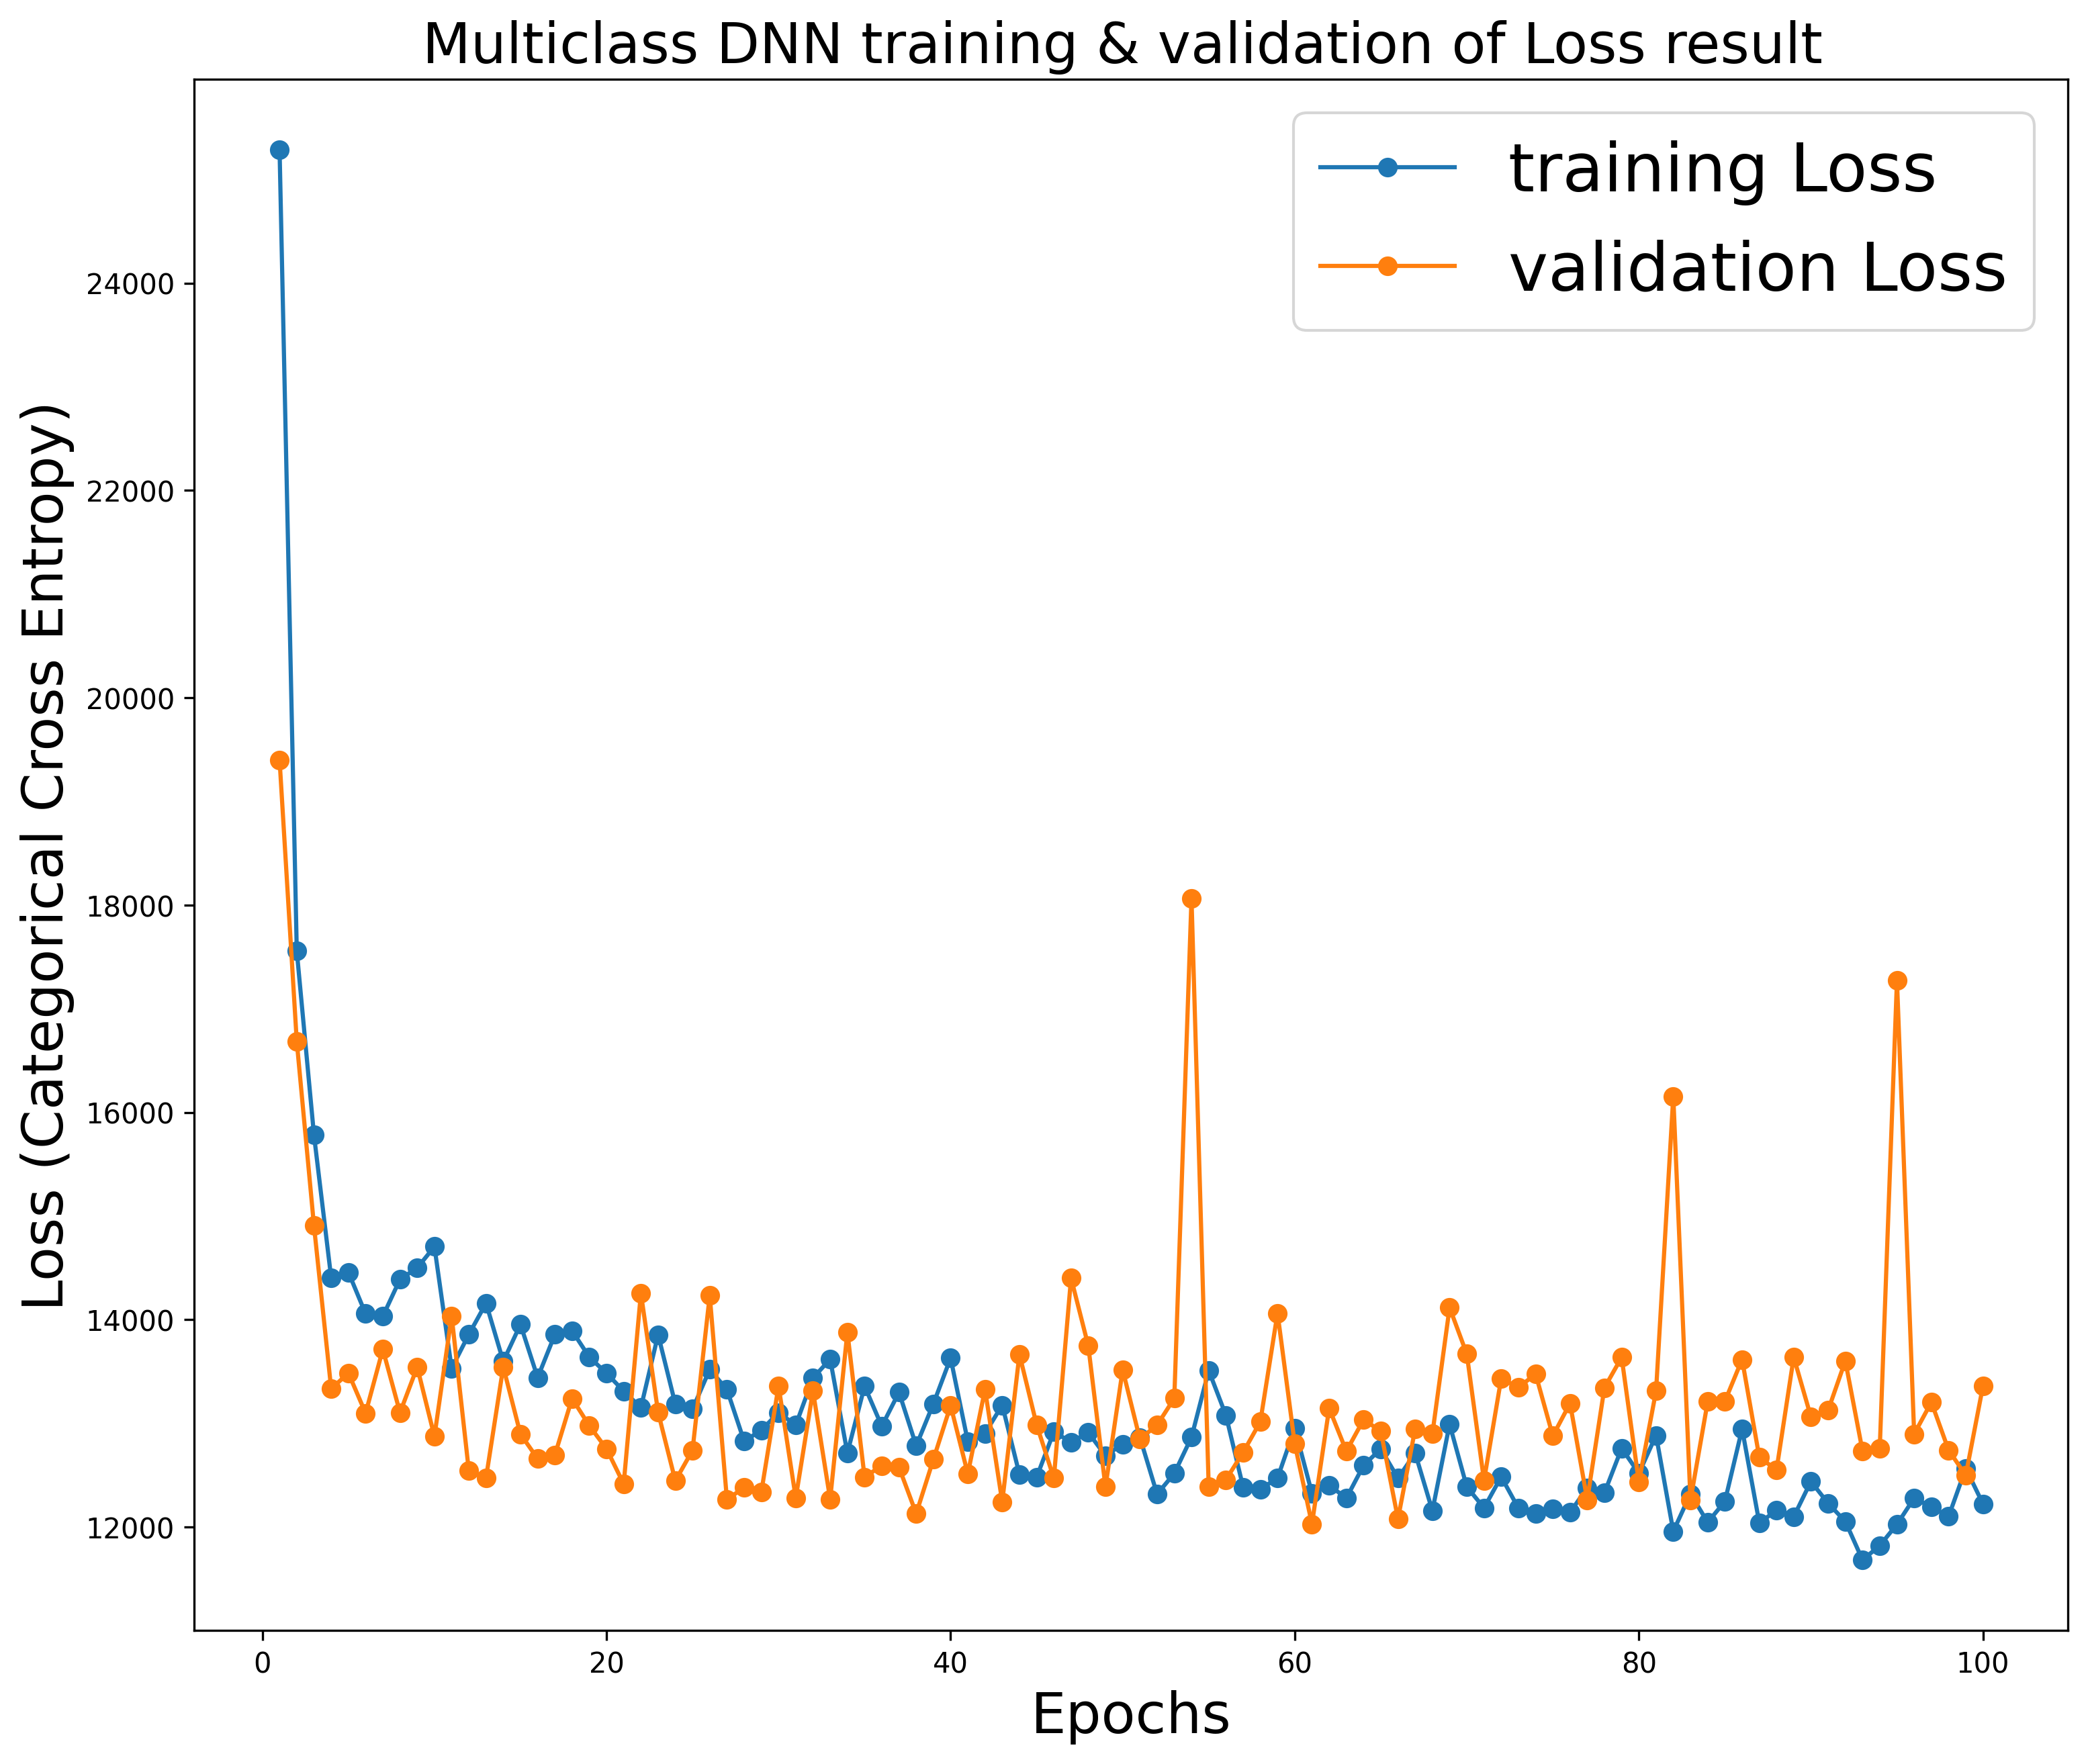

In [82]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [41]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,3,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.001,beta_1=0.5)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [42]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 1s 15ms/step - loss: 24996.7773 - MAPE: 69.0174 - val_loss: 23325.0684 - val_MAPE: 44.6069
Epoch 2/100
48/48 [==============================] - 0s 10ms/step - loss: 19185.4258 - MAPE: 51.1537 - val_loss: 17348.2715 - val_MAPE: 34.6905
Epoch 3/100
48/48 [==============================] - 1s 11ms/step - loss: 16195.2988 - MAPE: 43.6438 - val_loss: 14730.0635 - val_MAPE: 40.1654
Epoch 4/100
48/48 [==============================] - 0s 10ms/step - loss: 15926.8594 - MAPE: 43.2721 - val_loss: 13258.8486 - val_MAPE: 34.1522
Epoch 5/100
48/48 [==============================] - 1s 10ms/step - loss: 14980.3799 - MAPE: 40.3734 - val_loss: 14993.7578 - val_MAPE: 47.8192
Epoch 6/100
48/48 [==============================] - 0s 10ms/step - loss: 15088.2139 - MAPE: 41.1725 - val_loss: 13986.0732 - val_MAPE: 31.2764
Epoch 7/100
48/48 [==============================] - 0s 10ms/step - loss: 15025.1621 - MAPE: 41.6580 - val_loss: 13581.2930 - val_MAPE: 

In [43]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

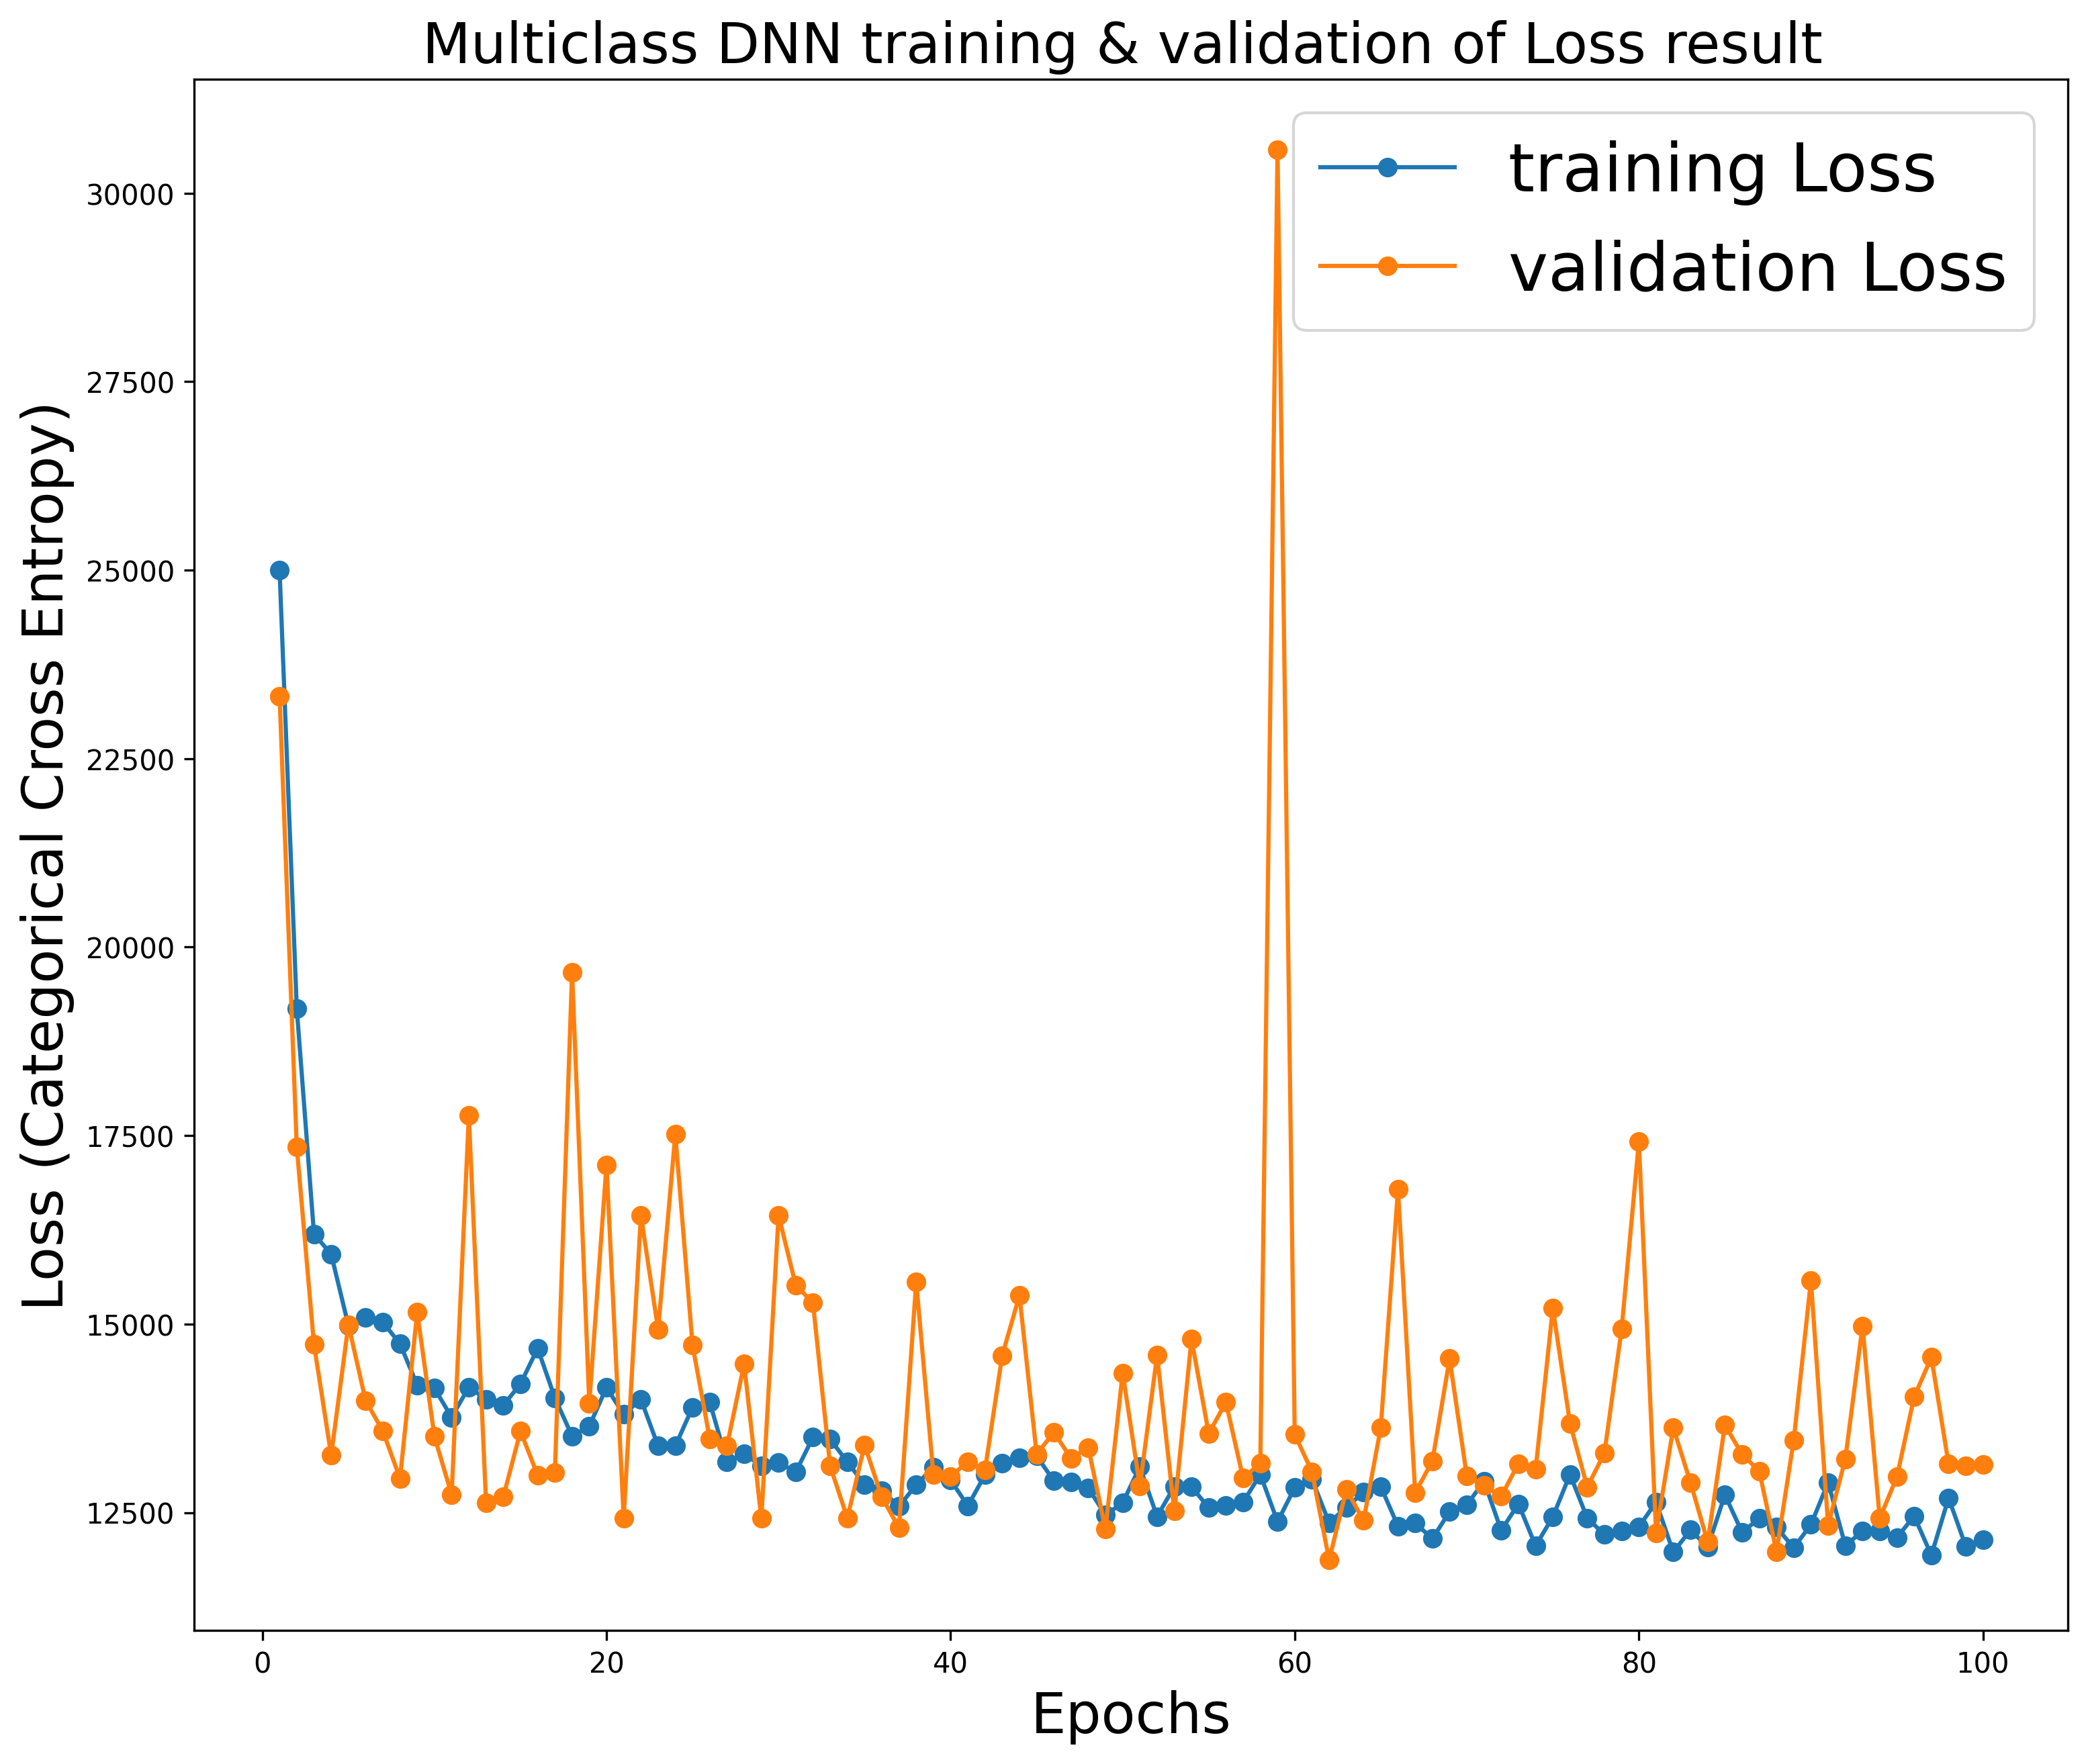

In [44]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [45]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,3,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.005,beta_1=0.5)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [46]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 1s 15ms/step - loss: 28698.4453 - MAPE: 84.6946 - val_loss: 31945.6133 - val_MAPE: 63.3356
Epoch 2/100
48/48 [==============================] - 0s 10ms/step - loss: 19809.4902 - MAPE: 55.4556 - val_loss: 24591.5020 - val_MAPE: 98.7314
Epoch 3/100
48/48 [==============================] - 0s 10ms/step - loss: 16599.4766 - MAPE: 46.6636 - val_loss: 17371.4980 - val_MAPE: 33.6230
Epoch 4/100
48/48 [==============================] - 0s 10ms/step - loss: 16508.2402 - MAPE: 42.7493 - val_loss: 13845.3359 - val_MAPE: 47.1323
Epoch 5/100
48/48 [==============================] - 1s 11ms/step - loss: 15282.6426 - MAPE: 43.1367 - val_loss: 13394.4629 - val_MAPE: 43.2273
Epoch 6/100
48/48 [==============================] - 0s 10ms/step - loss: 14785.6084 - MAPE: 41.0720 - val_loss: 13031.9824 - val_MAPE: 37.0020
Epoch 7/100
48/48 [==============================] - 1s 11ms/step - loss: 15996.5010 - MAPE: 42.7979 - val_loss: 13438.9971 - val_MAPE: 

In [47]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

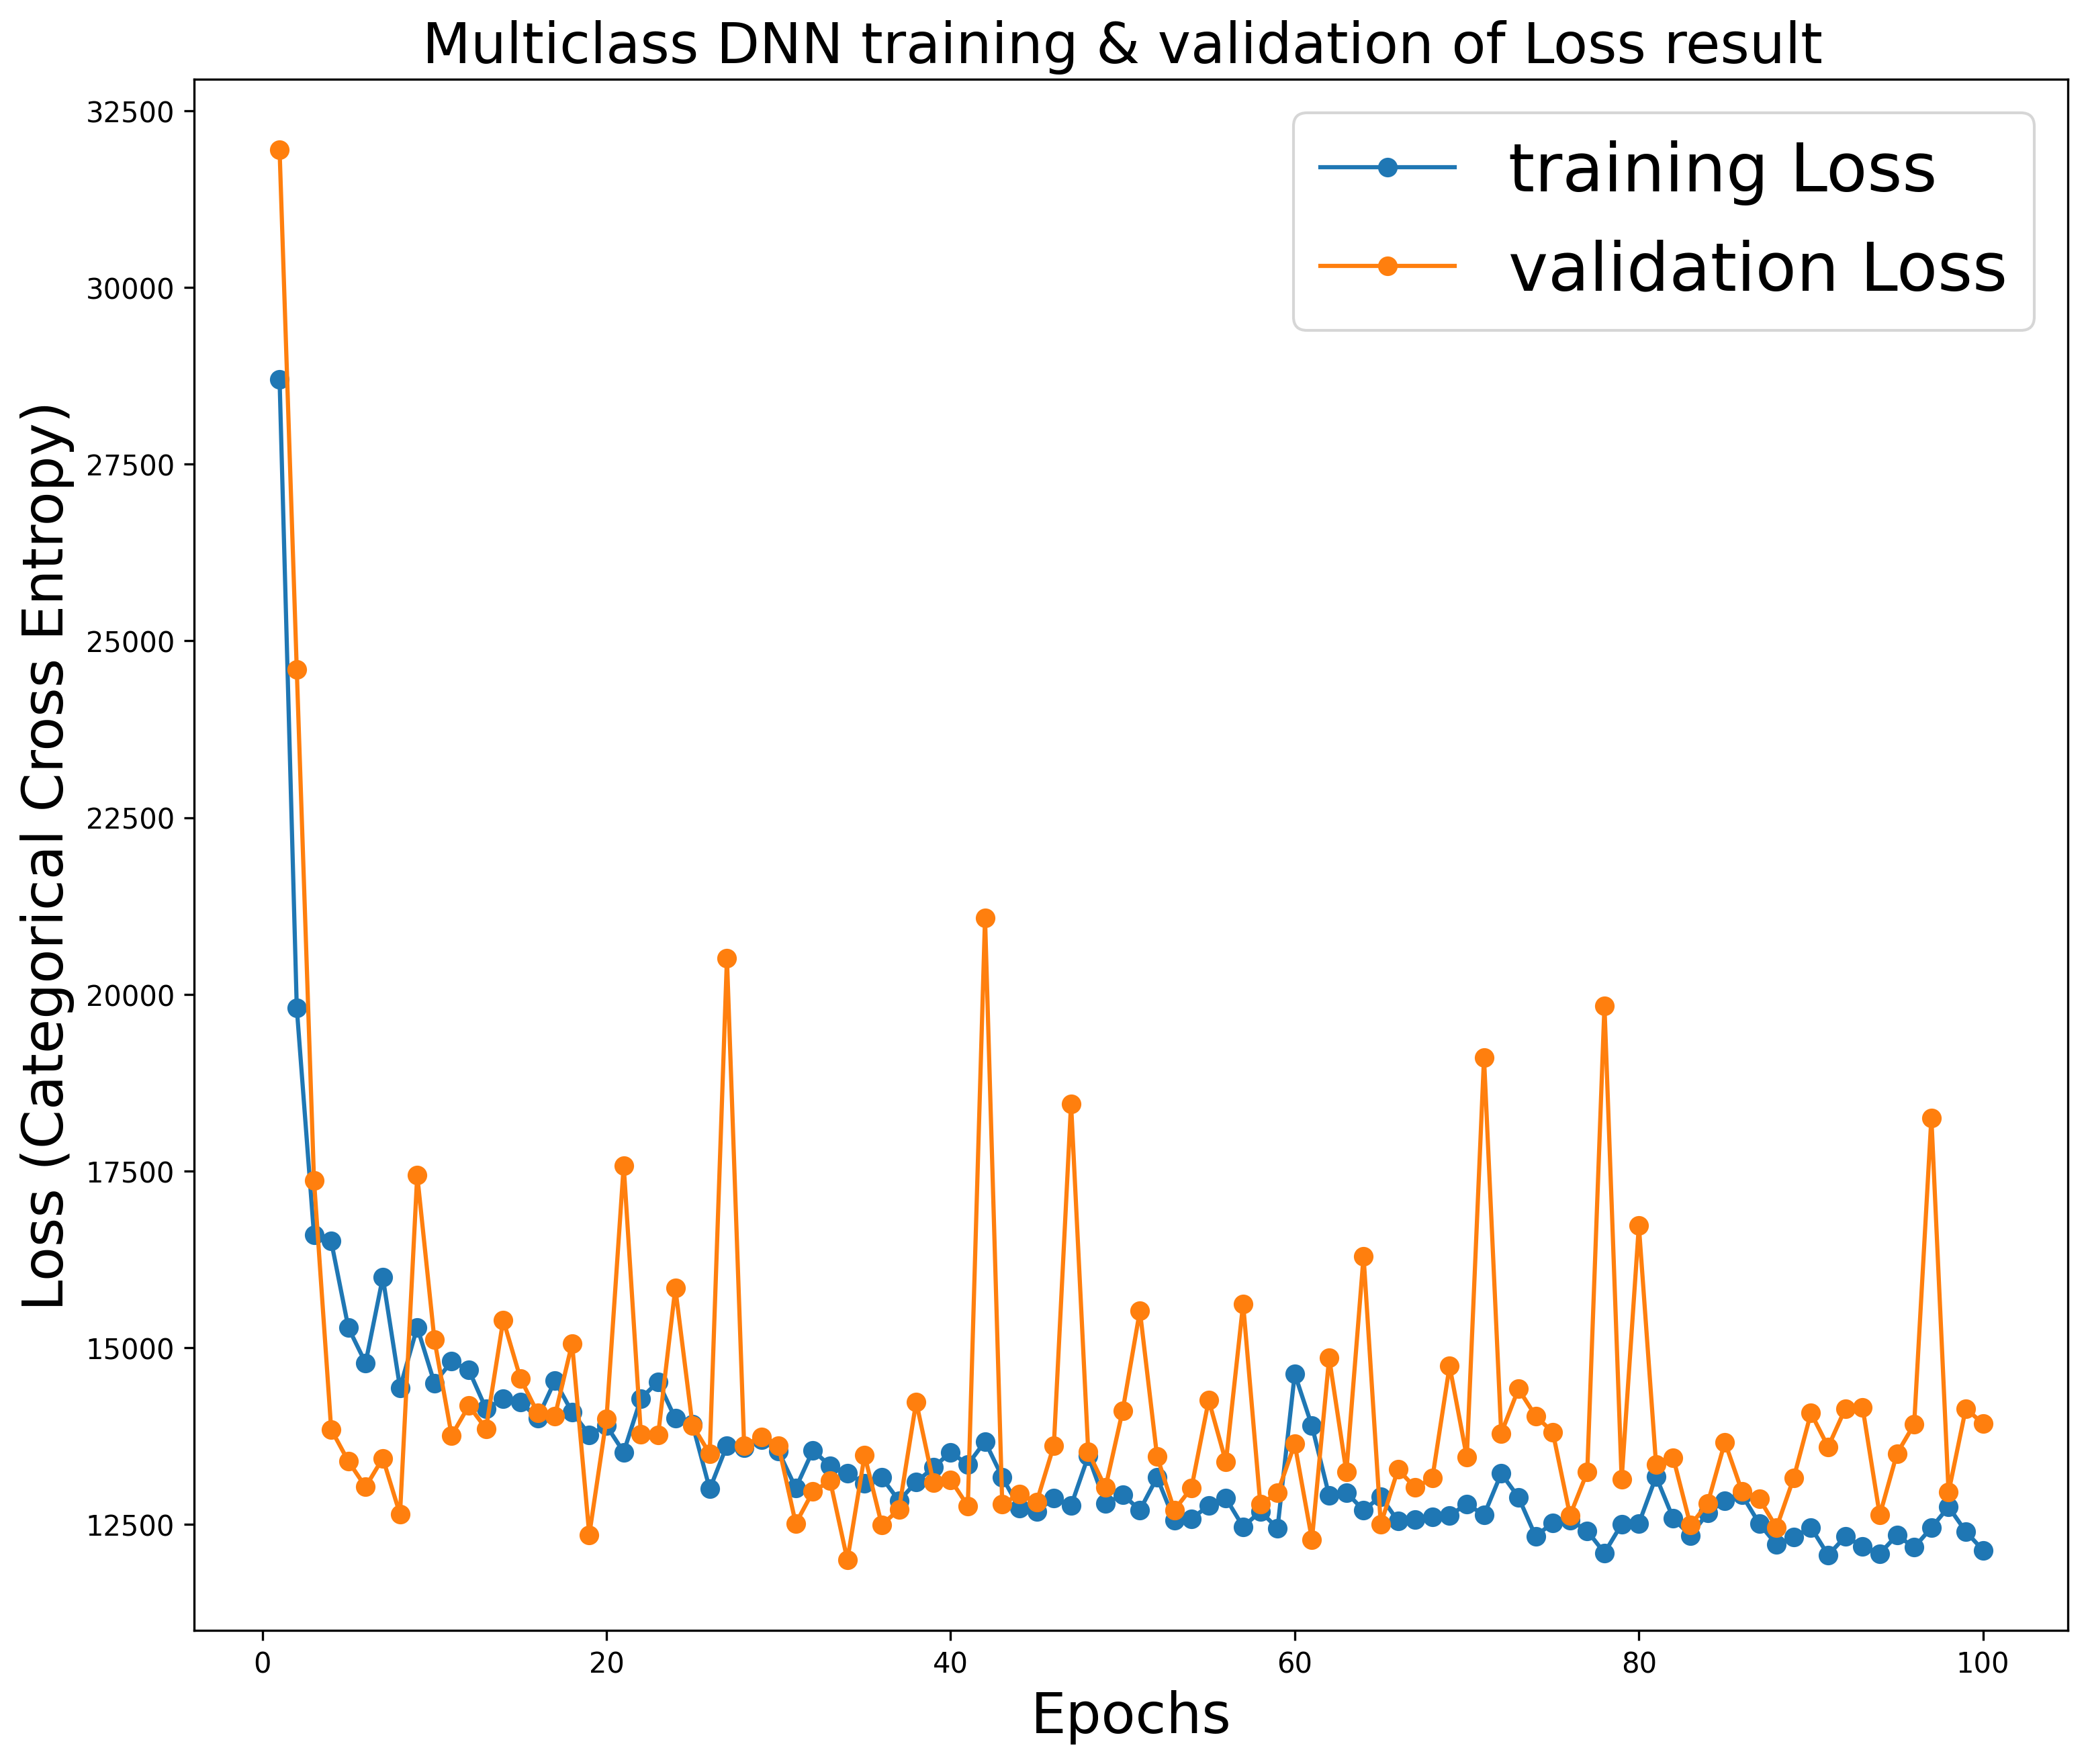

In [48]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,5,768)


# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.005,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss
# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 7s 120ms/step - loss: 30198.4473 - MAPE: 101.6532 - val_loss: 21152.1230 - val_MAPE: 41.8819
Epoch 2/100
48/48 [==============================] - 6s 118ms/step - loss: 19237.9512 - MAPE: 52.3955 - val_loss: 14271.3496 - val_MAPE: 38.3991
Epoch 3/100
48/48 [==============================] - 6s 119ms/step - loss: 17233.6836 - MAPE: 49.9651 - val_loss: 17411.3262 - val_MAPE: 58.0759
Epoch 4/100
48/48 [==============================] - 6s 117ms/step - loss: 19444.1719 - MAPE: 57.3566 - val_loss: 16268.5127 - val_MAPE: 38.1253
Epoch 5/100
48/48 [==============================] - 6s 117ms/step - loss: 15046.7969 - MAPE: 40.5186 - val_loss: 13267.1172 - val_MAPE: 32.9393
Epoch 6/100
48/48 [==============================] - 6s 118ms/step - loss: 14956.2227 - MAPE: 40.6319 - val_loss: 13927.9971 - val_MAPE: 54.5691
Epoch 7/100
48/48 [==============================] - 6s 115ms/step - loss: 16340.3350 - MAPE: 45.6504 - val_loss: 17272.4863 - va

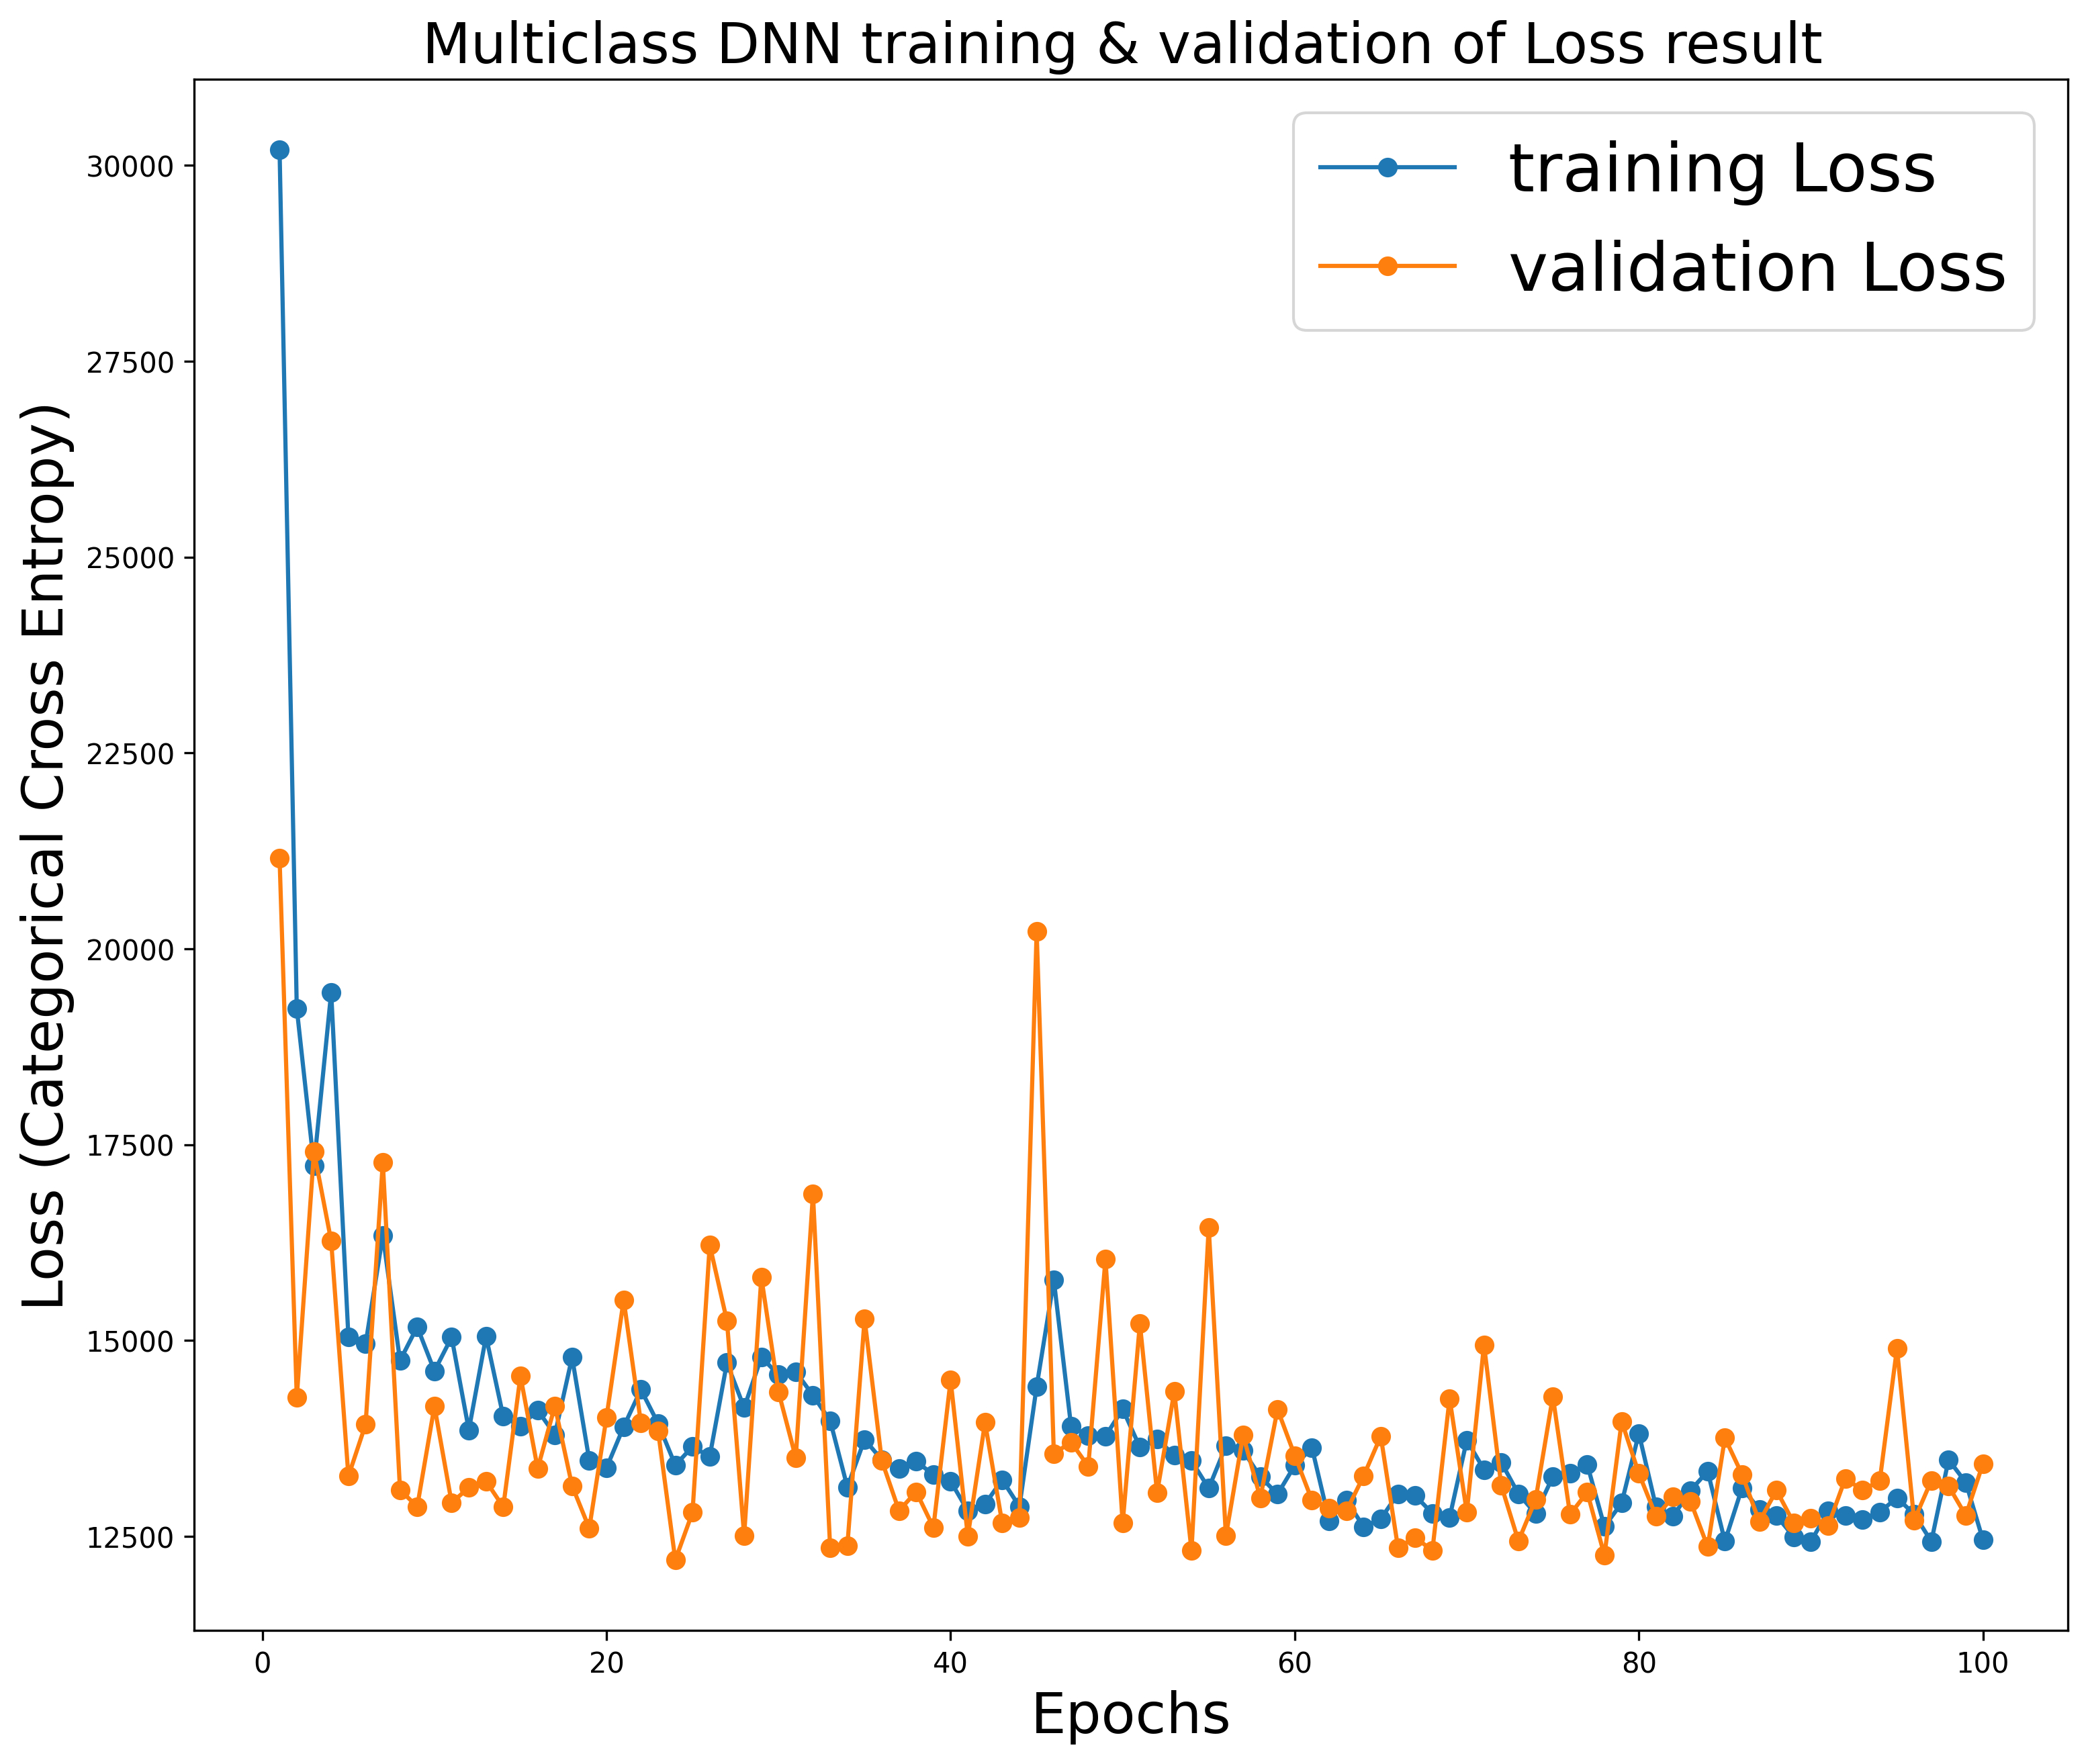

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()